# Donwloading Necessary Packages 

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import pandas as pd
import itertools

import sys
from pathlib import Path
functions_path = Path("/home/mokr/Loss_Functions_Paper/ML_Functions/")
sys.path.append(str(functions_path))

import ML_functions
from ML_functions import HydroDataset

import torch
import torch.nn as nn
from collections import defaultdict
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from ML_Plots import kl_divergence, CMAL_quantile, transform_CMAL_parameters, draw_from_CMAL_distribution, draw_from_CMAL_distribution_np, load_and_unnormalize, get_ensemble_members_vectorized, plot_ensemble_predictions, generate_greedy_trajectories, plot_dispersion_histograms, plot_uniform_qq, load_and_unnormalize

from ML_Losses import compute_log_likelihood, compute_CDF, crps_loss, compute_crps, calculate_overall_crps, get_member_summaries_torch , compute_nse, compute_kge

from ML_functions import transform_CMAL_parameters_multi, run_ensemble_predictions

# Downloading data and models

- Making a general validation dataloader
- Making seperate dataloaders for each of the three focus basins
    - hysets_11477000 catchment in California	
    - hysets_12324400 medium catchment in Montana
    - hysets_01358000 Hudson river New York

In [ ]:
CRPS_Binary_Model =  torch.load('/home/mokr/Loss_Functions_Paper/Models/Binary/hyperparameter_test/Binary_lr_0.001_bi_False_h_256_256_256_0506_30Epochs.pth', map_location=torch.device('cpu')) # BEST CRPS Model, 46
# NLL_Binary_Model =  torch.load('/home/mokr/Loss_Functions_Paper/Models/Binary/hyperparameter_test/NonBinary_lr_0.001_bi_False_h_256_256_64_0505_5Epochs.pth', map_location=torch.device('cpu')) # BEST NLL Model loss -15
NonBinary_Model = torch.load('/home/mokr/Loss_Functions_Paper/Models/NonBinary/hyperparameter_test/NonBinary_lr_0.001_bi_False_h_128_128_64_0503_30Epochs.pth', map_location=torch.device('cpu')) # Best NonBinary models so far

Fixed_Noise_Seeded_Model = torch.load('/home/mokr/Loss_Functions_Paper/Models/Seeded/hyperparameter_test/Seeded_lr_0.001_bi_False_h_256_256_128_0901_16_0.7_5_True_Epochs.pth', map_location=torch.device('cpu')) # 0.074 val loss Best Seeded Model so far
Non_Fixed_Noise_Seeded_Model = torch.load('/home/mokr/Loss_Functions_Paper/Models/Seeded/hyperparameter_test/Seeded_lr_0.001_bi_False_h_256_256_128_0901_16_0.7_5_False_Epochs.pth', map_location=torch.device('cpu')) # 0.076 val loss
NLL_Binary_Model = CRPS_Binary_Model

In [ ]:
loaded_validation_data = torch.load("/perm/mokr/10Day_Loss_Function_Validation_Dataset_Binary_P0.pt")
Validation_Dataloader = DataLoader(loaded_validation_data, batch_size= 1, shuffle=True, pin_memory=True)

target_ids = ['hysets_11477000', 'hysets_12324400', 'hysets_01358000']


# Create a dictionary to hold lists for each target ID
filtered_data = {station_id: [] for station_id in target_ids}

# Loop through your data and distribute accordingly
for entry in loaded_validation_data:
    key = entry[4]
    if key in filtered_data:
        filtered_data[key].append(entry)

# Unpack to individual variables (optional)
hysets_11477000_data = filtered_data['hysets_11477000']
hysets_12324400_data = filtered_data['hysets_12324400']
hysets_01358000_data = filtered_data['hysets_01358000']


Hysets_11477000_Dataloader = DataLoader(hysets_11477000_data, batch_size= 1, shuffle=False, pin_memory=True)
Hysets_12324400_Dataloader = DataLoader(hysets_12324400_data, batch_size= 1, shuffle=False, pin_memory=True)
Hysets_01358000_Dataloader = DataLoader(hysets_01358000_data, batch_size= 1, shuffle=False, pin_memory=True)


In [17]:
loaded_validation_data = torch.load("/perm/mokr/10Day_Loss_Function_Validation_Dataset_Binary_P1.pt")

/etc/ecmwf/ssd/ssd1/jupyterhub/mokr-jupyterhub/tmpdirs/mokr.42695391/ipykernel_675990/858835745.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_validation_data = 

In [18]:
Validation_Dataloader = DataLoader(loaded_validation_data, batch_size= 1, shuffle=True, pin_memory=True)

len(Validation_Dataloader)

349650

In [19]:
scaler_path='/home/mokr/Loss_Functions_Paper/Scalers/discharge_caravan_scalers.joblib'

# Running models and storing results

- Hydrograph results for each of the locations and models
- Per day CRPS scores
- Overall CRPS scores

In [2]:
import importlib
sys.path.append(str(functions_path))
import ML_Losses
importlib.reload(ML_Losses)
from ML_Losses import get_member_summaries_torch, compute_kge


In [9]:
Validation_Dataloader = DataLoader(loaded_validation_data, batch_size= 1, shuffle=True, pin_memory=True)


In [22]:
def get_nonbinary_ensemble_members(model, Hist_X_Chunk_Torch, Fore_X_Chunk_Torch, num_members=1, keep_original = False, device='cpu'):
    """
    Generate ensemble predictions for discharge.
    
    Args:
        model (torch.nn.Module): The trained machine learning model
        Hist_X_Chunk_Torch (torch.Tensor): Historical input chunk (batch size, num_steps, num_variables)
        Fore_X_Chunk_Torch (torch.Tensor): Forecast input chunk 
        num_members (int, optional): Number of ensemble members to generate. Defaults to 1.
    
    Returns:
        torch.Tensor: Ensemble predictions of discharge
    """
    
    num_steps = Fore_X_Chunk_Torch.shape[1]
    batch_size = Fore_X_Chunk_Torch.shape[0]

    hist_steps = Hist_X_Chunk_Torch.shape[1]
    
    # Repeat historical input for all ensemble members
    Hist_X_Chunk_Torch_repeated = Hist_X_Chunk_Torch.repeat(num_members, 1, 1, 1)
    Fore_X_Chunk_Torch_repeated = Fore_X_Chunk_Torch.repeat(num_members, 1, 1, 1)

    Original_Predictions = torch.zeros(num_members, batch_size, num_steps, 1, device=device)
    Original_Predictions_Saved = torch.zeros(num_members, batch_size, num_steps, 1, device=device)
    Discharge_Mask = torch.zeros(num_members, batch_size, num_steps, 1, device=device)

          


    #treat the ensembles and batch_size as one big batch set so the dimension is 3 again
    Binary_Fore_X_Chunk_Torch = Fore_X_Chunk_Torch_repeated.reshape(num_members * batch_size, num_steps, -1)
    Hist_X_Chunk_Torch_repeated = Hist_X_Chunk_Torch_repeated.reshape(num_members * batch_size, hist_steps, -1)

    with torch.no_grad():            
        param_predictions = model(
            Hist_X_Chunk_Torch_repeated.to(torch.float32), 
            Binary_Fore_X_Chunk_Torch.to(torch.float32)
        )[1]
        
    for step in range(num_steps):    
        # Transform parameters and draw samples
        param_predictions_step = ML_functions.transform_CMAL_parameters_multi(param_predictions)[:, step]
        
        param_prediction = {
            'mu': param_predictions_step[:, ::4],   # mu is at indices 0 mod 4
            'b': param_predictions_step[:, 1::4],   # b is at indices 1 mod 4 (ensure positive)
            'tau': param_predictions_step[:, 2::4], # tau is at indices 2 mod 4 (ensure 0-1)
            'pi': param_predictions_step[:, 3::4],  # pi is at indices 3 mod 4
        }

    
        # Draw samples for each ensemble member
        samples = draw_from_CMAL_distribution(param_prediction, num_samples=1)
        
        # Update predictions and masks
        Original_Predictions_Saved[:, :, step, :] = samples.clone().detach().reshape(num_members, batch_size, 1)

    return Original_Predictions_Saved.squeeze()


In [ ]:
def process_ensemble_predictions(model_predictions, true_discharge, basin_idx,
                               ensemble_summaries, crps_per_leadtime, variogram_scores, stored_forecasts,
                               NSE_scores, KGE_scores, basin_forecasts, variogram_p = 1):
    """
    Process ensemble predictions for evaluation metrics in a versatile way.
    
    Args:
        model_predictions: Dictionary with model names as keys and prediction tensors as values
                          e.g., {"CRPS": tensor, "NLL": tensor, "Fixed_Seeded": tensor, ...}
        true_discharge: Ground truth discharge values
        basin_idx: Basin index or list of basin indices
        ensemble_summaries, crps_per_leadtime, etc.: Output dictionaries
    """
    
    # Process each model's predictions
    for model_name, predictions in model_predictions.items():
        if model_name == "Discharge":  # Skip if discharge is accidentally passed as a model
            continue
            
        # Ensemble summaries
        if model_name in ensemble_summaries:
            ensemble_summaries[model_name].append(get_member_summaries_torch(predictions))

        
        # CRPS per leadtime
        if model_name in crps_per_leadtime:
            crps_per_leadtime[model_name].append(compute_crps(predictions, true_discharge))
            variogram_scores[model_name].append(variogram_score_torch(predictions, true_discharge, variogram_p))
        
        # Stored forecasts
        if model_name in stored_forecasts:
            stored_forecasts[model_name].append(predictions)
        
        # NSE scores
        if model_name in NSE_scores:
            NSE_scores[model_name].append(compute_nse(true_discharge.squeeze(), predictions.squeeze()[0]))
        
        # KGE scores
        if model_name in KGE_scores:
            KGE_scores[model_name].append(compute_kge(true_discharge.squeeze(), predictions.squeeze()[0]))
        
        # Basin forecasts
        if basin_idx in basin_forecasts and model_name in basin_forecasts[basin_idx]:
            basin_forecasts[basin_idx][model_name].append(predictions[:, 0, :])
    
    # Handle discharge (ground truth) separately
    if "Discharge" in ensemble_summaries:
        ensemble_summaries["Discharge"].append(get_member_summaries_torch(true_discharge.unsqueeze(0)))
    
    if "Discharge" in stored_forecasts:
        stored_forecasts["Discharge"].append(true_discharge)
    
    if basin_idx in basin_forecasts and "Discharge" in basin_forecasts[basin_idx]:
        basin_forecasts[basin_idx]["Discharge"].append(true_discharge[0, :])



In [5]:
ensemble_summaries = {
    "CRPS": [],
    "NLL": [],
    "Fixed_Seeded": [],
    "Non_Fixed_Seeded": [],
    "NonBinary": [],
    "Discharge": []
}


variogram_scores = {    
    "CRPS": [],
    "NLL": [],
    "Fixed_Seeded": [],
    "Non_Fixed_Seeded": [],
    "NonBinary": []
}


crps_per_leadtime = {
    "CRPS": [],
    "NLL": [],
    "Fixed_Seeded": [],
    "Non_Fixed_Seeded": [],
    "NonBinary": []
}

stored_forecasts = {
    "CRPS": [],
    "NLL": [],
    "Fixed_Seeded": [],
    "Non_Fixed_Seeded": [],
    "NonBinary": [],
    "Discharge": []
}

KGE_scores = {
    "CRPS": [],
    "NLL": [],
    "Fixed_Seeded": [],
    "Non_Fixed_Seeded": [],
    "NonBinary": []
}

NSE_scores = {
    "CRPS": [],
    "NLL": [],
    "Fixed_Seeded": [],
    "Non_Fixed_Seeded": [],
    "NonBinary": []
}


# Store forecasts by basin and model
basin_forecasts = {}

dates = []
basins = []

In [6]:
def variogram_score_torch(ensemble_predictions, true_values, p=1.0):
    """    
    The variogram score is the mean squared error between the empirical variogram
    of the ensemble and the variogram of the observations:
    
    VS = (1/T^2) * sum_i sum_j (E[|X_i - X_j|^p] - |Y_i - Y_j|^p)^2
    
    where X are ensemble members, Y are observations, i,j index time steps, 
    and E is the expectation over ensemble members.
    
    Parameters:
    -----------
    ensemble_predictions : torch.Tensor
        Shape (n_ensemble, n_features, n_timesteps)
        Ensemble forecast predictions
    true_values : torch.Tensor
        Shape (n_features, n_timesteps)
        True observed values
    p : float, default=1.0
        Power parameter for the variogram (typically 0.5 or 1.0)
    
    Returns:
    --------
    vs : torch.Tensor
        Variogram score (0 is perfect)
    """
    # Reshape
    ensemble = ensemble_predictions.squeeze(dim=1)  # (n_ensemble, n_timesteps)
    true = true_values.squeeze(dim=0)  # (n_timesteps,)
    
    n_ensemble, n_timesteps = ensemble.shape
    
    # Compute pairwise differences for ensemble: |X_i - X_j|^p
    # Shape: (n_ensemble, n_timesteps, n_timesteps)
    ens_i = ensemble.unsqueeze(2)  # (n_ensemble, n_timesteps, 1)
    ens_j = ensemble.unsqueeze(1)  # (n_ensemble, 1, n_timesteps)
    pairwise_ens = torch.abs(ens_i - ens_j) ** p  # (n_ensemble, n_timesteps, n_timesteps)


    
    # Average over ensemble members: E[|X_i - X_j|^p]
    # Shape: (n_timesteps, n_timesteps)
    ensemble_variogram = torch.mean(pairwise_ens, dim=0)
    
    # Compute pairwise differences for observations: |Y_i - Y_j|^p
    # Shape: (n_timesteps, n_timesteps)
    true_i = true.unsqueeze(1)  # (n_timesteps, 1)
    true_j = true.unsqueeze(0)  # (1, n_timesteps)
    true_variogram = torch.abs(true_i - true_j) ** p  # (n_timesteps, n_timesteps)

    
    # Variogram score: MSE between ensemble and true variograms
    individual_scores = (ensemble_variogram - true_variogram) ** 2
    vs = torch.mean((ensemble_variogram - true_variogram) ** 2)
    
    return vs


In [13]:
Hysets_01358000_Dataloader = DataLoader(hysets_01358000_data, batch_size= 1, shuffle=False, pin_memory=True)
Hysets_11477000_Dataloader = DataLoader(hysets_11477000_data, batch_size= 1, shuffle=False, pin_memory=True)
Hysets_12324400_Dataloader = DataLoader(hysets_12324400_data, batch_size= 1, shuffle=False, pin_memory=True)

In [39]:
for i, (Hist_X_Chunk_Torch, Fore_X_Chunk_Torch, Y_value, date_idx, basin_idx) in enumerate(Validation_Dataloader):
    
    if torch.isnan(Y_value).any():
        continue   
    
    if basin_idx not in basin_forecasts:
        basin_forecasts[basin_idx] = {"CRPS": [], "NLL": [], "Seeded": [], "NonBinary": [], "Discharge": []}
            
    Fore_X_Chunk_Torch_Flagless = Fore_X_Chunk_Torch[:,:, 0:15]
    
    num_members = 11
    num_steps = Fore_X_Chunk_Torch.shape[1]

    # Get the members of the CRPS, CMAL, and NonBinary models, unnormalise them and clip them to only predict positive discharge
    CRPS_ensemble_predictions =  get_ensemble_members_vectorized(CRPS_Binary_Model, Hist_X_Chunk_Torch, Fore_X_Chunk_Torch[:,:,0:15], num_members= num_members, keep_original = False)
    NLL_ensemble_predictions =  get_ensemble_members_vectorized(NLL_Binary_Model, Hist_X_Chunk_Torch, Fore_X_Chunk_Torch[:,:,0:15], num_members= num_members, keep_original = False)
    NonBinary_ensemble_predictions = get_nonbinary_ensemble_members(NonBinary_Model, Hist_X_Chunk_Torch, Fore_X_Chunk_Torch[:,:,0:15], num_members= num_members, keep_original = False)
    
    CRPS_ensemble_predictions, NLL_ensemble_predictions, NonBinary_ensemble_predictions = CRPS_ensemble_predictions.unsqueeze(1), NLL_ensemble_predictions.unsqueeze(1), NonBinary_ensemble_predictions.unsqueeze(1)

    CRPS_ensemble_predictions[CRPS_ensemble_predictions < -0.26787253] = -0.2678724
    NLL_ensemble_predictions[NLL_ensemble_predictions < -0.26787253] = -0.2678724   
    NonBinary_ensemble_predictions[NonBinary_ensemble_predictions < -0.26787253] = -0.2678724   


    CRPS_ensemble_predictions, true_discharge = load_and_unnormalize(CRPS_ensemble_predictions, Y_value, scaler_path)
    NLL_ensemble_predictions, _ = load_and_unnormalize(NLL_ensemble_predictions, Y_value, scaler_path)
    NonBinary_ensemble_predictions, _ = load_and_unnormalize(NonBinary_ensemble_predictions, Y_value, scaler_path)

    true_discharge[true_discharge < 0] = 0

    # Do the same for the Fixed_Seeded and Non_Fixed_Seeded models
    Fixed_Seeded_ensemble_predictions = run_ensemble_predictions(Fixed_Noise_Seeded_Model, Hist_X_Chunk_Torch.to(torch.float32), Fore_X_Chunk_Torch_Flagless.to(torch.float32), num_members=num_members, noise_scale=1.0)
    Fixed_Seeded_ensemble_predictions[Fixed_Seeded_ensemble_predictions < -0.26787253] = -0.2678724   
    Fixed_Seeded_ensemble_predictions = Fixed_Seeded_ensemble_predictions.squeeze().unsqueeze(1)
    Fixed_Seeded_ensemble_predictions, _ = load_and_unnormalize(Fixed_Seeded_ensemble_predictions.detach(), Y_value)

    Non_Fixed_Seeded_ensemble_predictions = run_ensemble_predictions(Non_Fixed_Noise_Seeded_Model, Hist_X_Chunk_Torch.to(torch.float32), Fore_X_Chunk_Torch_Flagless.to(torch.float32), num_members=num_members, noise_scale=1.0)
    Non_Fixed_Seeded_ensemble_predictions[Non_Fixed_Seeded_ensemble_predictions < -0.26787253] = -0.2678724   
    Non_Fixed_Seeded_ensemble_predictions = Non_Fixed_Seeded_ensemble_predictions.squeeze().unsqueeze(1)
    Non_Fixed_Seeded_ensemble_predictions, _ = load_and_unnormalize(Non_Fixed_Seeded_ensemble_predictions.detach(), Y_value)
    
    
    # Convert everything to torch
    CRPS_ensemble_predictions, NLL_ensemble_predictions, Fixed_Seeded_ensemble_predictions, Non_Fixed_Seeded_ensemble_predictions, NonBinary_ensemble_predictions, true_discharge = map(
        lambda x: torch.from_numpy(x).float(),
        [CRPS_ensemble_predictions, NLL_ensemble_predictions, Fixed_Seeded_ensemble_predictions, Non_Fixed_Seeded_ensemble_predictions, NonBinary_ensemble_predictions, true_discharge]
    )
     

    
    # Store necessary information
    
    # CRPS

    model_preds = {
    "CRPS": CRPS_ensemble_predictions,
    "NLL": NLL_ensemble_predictions,
    "Fixed_Seeded": Fixed_Seeded_ensemble_predictions,
    "Non_Fixed_Seeded": Non_Fixed_Seeded_ensemble_predictions,
    "NonBinary": NonBinary_ensemble_predictions
    }

    process_ensemble_predictions(model_preds, true_discharge, basin_idx,
                           ensemble_summaries, crps_per_leadtime, variogram_scores, stored_forecasts,
                           NSE_scores, KGE_scores, basin_forecasts, variogram_p = 0.5)
    

    if Y_value[0][4]  > 10.85:
        print(basin_idx[0], date_idx[0], i)

        # plot_ensemble_predictions(CRPS_ensemble_predictions[:,0,:].squeeze().numpy(), true_discharge= true_discharge[0,:].squeeze().numpy(), title = 'CRPS Conditionally Derived Ensemble', plot_type='ensemble')
        # plot_ensemble_predictions(NonBinary_ensemble_predictions[:,0,:].squeeze().numpy(), true_discharge= true_discharge[0,:].squeeze().numpy(), title = 'Random Ensemble', plot_type='ensemble')
        # # plot_ensemble_predictions(NLL_ensemble_predictions.squeeze().numpy(), true_discharge= true_discharge.squeeze().numpy(), title = 'NLL Conditionally Derived Ensemble', plot_type='both')
        # plot_ensemble_predictions(Fixed_Seeded_ensemble_predictions.squeeze().numpy(), true_discharge= true_discharge.squeeze().numpy(), title = 'Fixed_Seeded Ensemble', plot_type='ensemble')
        # plot_ensemble_predictions(Non_Fixed_Seeded_ensemble_predictions.squeeze().numpy(), true_discharge= true_discharge.squeeze().numpy(), title = 'Non_Fixed_Seeded Ensemble', plot_type='ensemble')

        max_val = max(
            CRPS_ensemble_predictions[:, :, :].max().item(), NonBinary_ensemble_predictions[:, :, :].max().item(),
            Fixed_Seeded_ensemble_predictions.max().item(), Non_Fixed_Seeded_ensemble_predictions.max().item(),
            true_discharge[:, :].max().item()
        )
        
        # Add some padding so the top of the plot isn't touching the max
        ylims = (0, max_val * 1.05)
        
        # --- Plot with consistent y-axis limits ---
        plot_ensemble_predictions(CRPS_ensemble_predictions[:, 0, :].squeeze().numpy(), true_discharge=true_discharge[0, :].squeeze().numpy(),
            title='CRPS Conditionally Derived Ensemble', plot_type='ensemble', unnormalize=False, ylims=ylims)
    
        plot_ensemble_predictions(NonBinary_ensemble_predictions[:, 0, :].squeeze().numpy(), true_discharge=true_discharge[0, :].squeeze().numpy(),
            title='Random Ensemble', plot_type='ensemble', unnormalize = False, ylims=ylims)
    
        plot_ensemble_predictions(Fixed_Seeded_ensemble_predictions.squeeze().numpy(), true_discharge=true_discharge.squeeze().numpy(),
            title='Fixed_Seeded Ensemble', plot_type='ensemble', unnormalize = False, ylims=ylims)
    
        plot_ensemble_predictions(Non_Fixed_Seeded_ensemble_predictions.squeeze().numpy(), true_discharge=true_discharge.squeeze().numpy(),
            title='Non_Fixed_Seeded Ensemble', plot_type='ensemble', unnormalize = False, ylims=ylims)
    
    
    # Stores dates
    dates.append(date_idx)
    basins.append(basin_idx)
    if i % 200 == 0:
        print(i)

    if i > 1e4:
        break

0


KeyboardInterrupt: 

In [40]:
mean_variogram_scores = {}
for model_name, scores in variogram_scores.items():
    if len(scores) > 0:
        # Convert tensors to numpy if needed
        if isinstance(scores[0], torch.Tensor):
            scores_np = [s.item() if s.numel() == 1 else s.cpu().numpy() for s in scores]
        else:
            scores_np = scores
        
        mean_variogram_scores[model_name] = {
            'Mean': np.mean(scores_np),
            'Std': np.std(scores_np),
            'Min': np.min(scores_np),
            'Max': np.max(scores_np),
            'N_Inits': len(scores_np)
        }

# Create DataFrame
df = pd.DataFrame(mean_variogram_scores).T

# Sort by mean score (lower is better)
df = df.sort_values('Mean')

df


,Mean,Std,Min,Max,N_Inits
NLL,0.187816,0.767921,0.000444,23.632942,10002.0
CRPS,0.189467,0.772366,0.000596,24.956638,10002.0
Fixed_Seeded,0.208580,0.739224,0.000000,24.968128,10002.0
Non_Fixed_Seeded,0.211500,0.706342,0.000000,22.428696,10002.0
NonBinary,0.239550,0.914076,0.002254,31.440161,10002.0


In [7]:
print(Fixed_Seeded_ensemble_predictions.shape)
print(true_discharge.shape)

NameError: name 'Fixed_Seeded_ensemble_predictions' is not defined

In [7]:
def variogram_score(ensemble_predictions, true_values, p=1.0):
    """
    Calculate the variogram score for ensemble predictions.
    
    The variogram score measures the difference between the empirical variogram
    of the ensemble and the variogram between observations and ensemble.
    
    VS = E[|X_i - X_j|^p] - E[|Y_i - Y_j|^p]
    
    where X are ensemble members, Y are observations, and i,j index time steps.
    
    Parameters:
    -----------
    ensemble_predictions : np.ndarray
        Shape (n_ensemble, n_features, n_timesteps)
        Ensemble forecast predictions
    true_values : np.ndarray
        Shape (n_features, n_timesteps)
        True observed values
    p : float, default=1.0
        Power parameter for the variogram (typically 0.5 or 1.0)
    
    Returns:
    --------
    vs : float
        Variogram score (lower is better, 0 is perfect)
    """
    # Reshape
    ensemble = ensemble_predictions.squeeze(axis=1)  # (n_ensemble, n_timesteps)
    true = true_values.squeeze(axis=0)  # (n_timesteps,)
    
    n_ensemble, n_timesteps = ensemble.shape
    
    # Term 1: Average variogram within ensemble E[|X_i - X_j|^p]
    ens_i = ensemble[:, :, np.newaxis]  # (n_ensemble, n_timesteps, 1)
    ens_j = ensemble[:, np.newaxis, :]  # (n_ensemble, 1, n_timesteps)
    pairwise_ens = np.abs(ens_i - ens_j) ** p  # (n_ensemble, n_timesteps, n_timesteps)
    
    ensemble_variogram = np.mean(pairwise_ens, axis=0)
    print(ensemble_variogram.shape)
    
    # Compute pairwise differences for observations: |Y_i - Y_j|^p
    # Shape: (n_timesteps, n_timesteps)
    true_i = true[:, np.newaxis]  # (n_timesteps, 1)
    true_j = true[np.newaxis, :]  # (1, n_timesteps)
    true_variogram = np.abs(true_i - true_j) ** p  # (n_timesteps, n_timesteps)
    print(true_variogram.shape)
    
    # Variogram score: MSE between ensemble and true variograms
    vs = np.mean((ensemble_variogram - true_variogram) ** 2)
    
    return vs




# Loading Data

In [29]:
import os
import pickle

# Set the directory where your files are saved
data_dir = "/home/mokr/Loss_Functions_Paper/forecast_results/"

# Load all data from the combined file
# with open(os.path.join(data_dir, "all_forecast_data.pkl"), "rb") as f:
#     loaded_data = pickle.load(f)


# Define the variable names
variable_names = [
    "ensemble_summaries",
    "crps_per_leadtime",
    "stored_forecasts",
    # "KGE_scores",
    # "NSE_scores",
    # "basin_forecasts",
    "variogram_scores",
    "metadata",

]

# Load each file into its corresponding variable
loaded_data = {}
for name in variable_names:
    with open(os.path.join(data_dir, f"{name}_Part0_all_test.pkl"), "rb") as f:
        loaded_data[name] = pickle.load(f)

ensemble_summaries = loaded_data["ensemble_summaries"]
crps_per_leadtime = loaded_data["crps_per_leadtime"]
stored_forecasts = loaded_data["stored_forecasts"]
# KGE_scores = loaded_data["KGE_scores"]
# NSE_scores = loaded_data["NSE_scores"]
# basin_forecasts = loaded_data["basin_forecasts"]
metadata = loaded_data["metadata"]
variogram_scores = loaded_data["variogram_scores"]


In [92]:

# 1. Extract Basin IDs from Metadata
# Since metadata is a structured array with fields, we can access 'basin_idx' directly.
# This avoids a slow Python loop.
basin_ids = metadata['basin_idx']

# Initialize a dictionary to hold the DataFrames for each model
catchment_crps_dfs = {}

for model in models:
    print(f"Processing {model}...")
    
    # 2. Create a temporary DataFrame with CRPS data and Basin IDs
    # crps_per_leadtime[model] shape: (695505, 10)
    df = pd.DataFrame(
        crps_per_leadtime[model], 
        columns=[f'Lead_{t}' for t in range(10)]
    )
    
    # Add the Basin ID column
    df['Basin'] = basin_ids
    
    # 3. Group by Basin and Calculate Mean
    # This results in a DataFrame where Index = Basin ID, Columns = Lead Times
    average_per_catchment = df.groupby('Basin').mean()
    
    catchment_crps_dfs[model] = average_per_catchment

# --- Example Usage ---
# View the first few rows for the 'Conditional' model
print("\nAverage CRPS per Catchment (Conditional Model):")
print(catchment_crps_dfs['Conditional'].head())

catchment_crps_dfs['Conditional']

Processing Conditional...
Processing Seeded (Static)...
Processing Seeded (Variable)...
Processing Probabilistic...

Average CRPS per Catchment (Conditional Model):
                     Lead_0    Lead_1    Lead_2    Lead_3    Lead_4    Lead_5  \
Basin                                                                           
camelsbr_35740000  0.256051  0.266298  0.270742  0.278394  0.285565  0.291548   
camelsbr_36580000  0.008620  0.008583  0.006654  0.006103  0.005656  0.005879   
camelsbr_39560000  0.083333  0.080601  0.078180  0.083429  0.088240  0.096605   
camelsbr_44200000  0.063327  0.053851  0.048675  0.046492  0.047926  0.049748   
camelsbr_44290002  0.064024  0.052074  0.045537  0.044039  0.044556  0.046038   

                     Lead_6    Lead_7    Lead_8    Lead_9  
Basin                                                      
camelsbr_35740000  0.295554  0.300541  0.303644  0.306040  
camelsbr_36580000  0.005858  0.005993  0.006152  0.007109  
camelsbr_39560000  0.097819

,Lead_0,Lead_1,Lead_2,Lead_3,Lead_4,Lead_5,Lead_6,Lead_7,Lead_8,Lead_9
Basin,,,,,,,,,,
camelsbr_35740000,0.256051,0.266298,0.270742,0.278394,0.285565,0.291548,0.295554,0.300541,0.303644,0.306040
camelsbr_36580000,0.008620,0.008583,0.006654,0.006103,0.005656,0.005879,0.005858,0.005993,0.006152,0.007109
camelsbr_39560000,0.083333,0.080601,0.078180,0.083429,0.088240,0.096605,0.097819,0.099725,0.103945,0.108917
camelsbr_44200000,0.063327,0.053851,0.048675,0.046492,0.047926,0.049748,0.052317,0.054974,0.058926,0.062414
camelsbr_44290002,0.064024,0.052074,0.045537,0.044039,0.044556,0.046038,0.049564,0.052896,0.056103,0.058559
...,...,...,...,...,...,...,...,...,...,...
hysets_14303600,0.911269,0.842641,0.763385,0.780625,0.894060,1.021401,1.102404,1.130499,1.213756,1.327334
hysets_14305500,1.320918,1.130603,1.128173,1.173812,1.228969,1.374712,1.449170,1.485616,1.643242,1.716855
hysets_14309500,0.664681,0.669251,0.670123,0.653628,0.646498,0.706274,0.718600,0.694317,0.727972,0.782919


Calculating normalized growth curves...


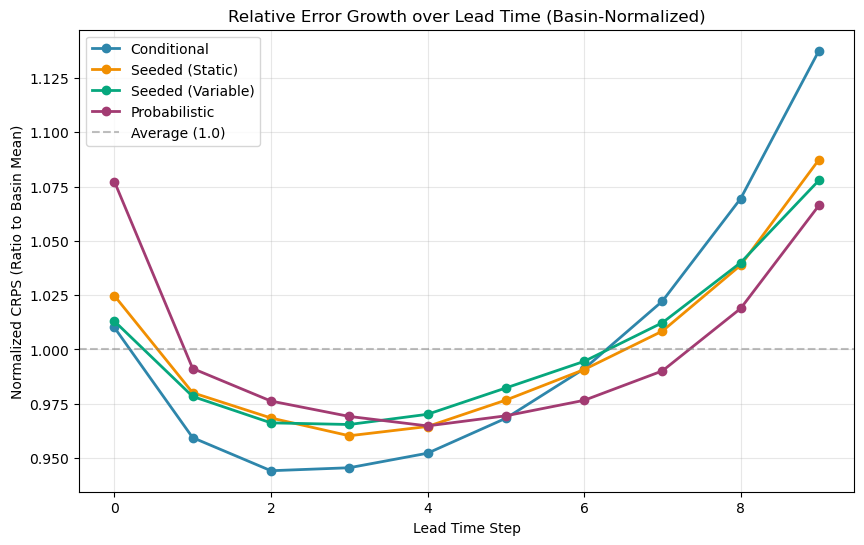

In [93]:
# catchment_crps_dfs[model] is a DataFrame: Index=BasinID, Columns=Lead_0..Lead_9

# Container for the final curves
normalized_curves = {}

print("Calculating normalized growth curves...")

for model in models:
    # Get the dataframe for this model
    df = catchment_crps_dfs[model]
    
    # 1. Calculate the mean CRPS for each catchment (Row Mean)
    # This represents the "average difficulty" of that basin for this specific model
    catchment_means = df.mean(axis=1)
    
    # 2. Divide each row by its mean
    # Result: A dataframe of ratios where ~1.0 is the average performance
    # We use div(..., axis=0) to align indices correctly
    normalized_df = df.div(catchment_means, axis=0)
    
    # 3. Calculate the overall mean at each lead time (Column Mean)
    # This gives us the shape of the error growth, independent of basin magnitude
    curve = normalized_df.mean(axis=0)
    
    normalized_curves[model] = curve

# ==========================================
# PLOT: Normalized CRPS Growth
# ==========================================
plt.figure(figsize=(10, 6))

lead_times = range(10) # 0 to 9

for model in models:
    curve = normalized_curves[model]
    
    plt.plot(lead_times, curve, 
             marker='o', linestyle='-', linewidth=2,
             color=model_colors[model], 
             label=model)

plt.xlabel('Lead Time Step')
plt.ylabel('Normalized CRPS (Ratio to Basin Mean)')
plt.title('Relative Error Growth over Lead Time (Basin-Normalized)')
plt.axhline(1.0, color='gray', linestyle='--', alpha=0.5, label='Average (1.0)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

Analyzing best performing lead times per catchment...


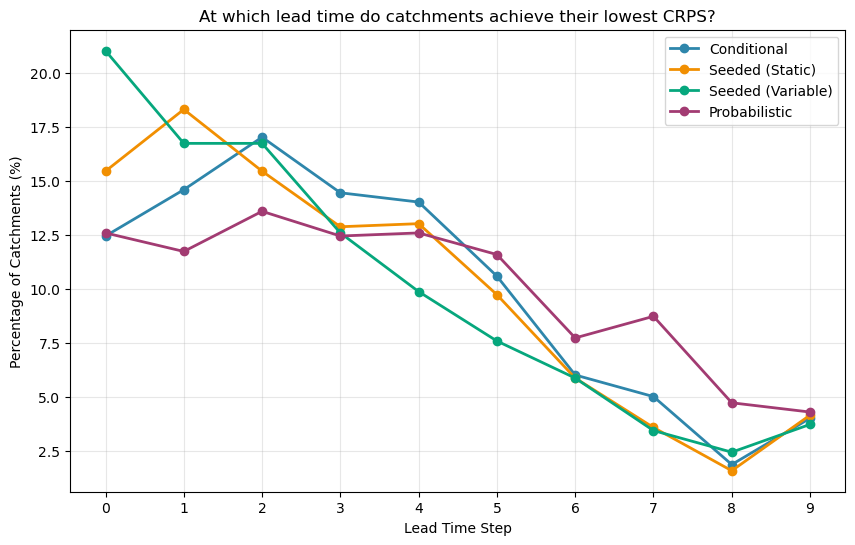


Percentage of catchments with lowest CRPS at Lead Time 0:
  Conditional: 12.4%
  Seeded (Static): 15.5%
  Seeded (Variable): 21.0%
  Probabilistic: 12.6%


In [94]:
# Container for the results
best_leadtime_counts = {}

# Lead times (integers 0-9)
lead_time_indices = range(10)

print("Analyzing best performing lead times per catchment...")

for model in models:
    df = catchment_crps_dfs[model]
    
    # 1. Find the column with the minimum CRPS for each row (catchment)
    # idxmin returns the column name (e.g., 'Lead_0')
    best_cols = df.idxmin(axis=1)
    
    # Extract the integer lead time from the column name (assuming 'Lead_X' format)
    # If your columns are just integers 0-9, you can skip the string splitting
    best_leads = best_cols.apply(lambda x: int(str(x).split('_')[-1]) if isinstance(x, str) else x)
    
    # 2. Count occurrences of each lead time
    # reindex ensures we have a count for every lead time, even if it's 0
    counts = best_leads.value_counts().reindex(lead_time_indices, fill_value=0)
    
    # 3. Convert to percentage
    total_catchments = len(df)
    percentages = (counts / total_catchments) * 100
    
    best_leadtime_counts[model] = percentages

# ==========================================
# PLOT: Distribution of Best Lead Times
# ==========================================
plt.figure(figsize=(10, 6))

for model in models:
    pcts = best_leadtime_counts[model]
    
    plt.plot(lead_time_indices, pcts, 
             marker='o', linestyle='-', linewidth=2,
             color=model_colors[model], 
             label=model)

plt.xlabel('Lead Time Step')
plt.ylabel('Percentage of Catchments (%)')
plt.title('At which lead time do catchments achieve their lowest CRPS?')
plt.xticks(lead_time_indices) # Ensure integer ticks
plt.legend()
plt.grid(True, alpha=0.3)

# Add a note explaining the expected trend
# Usually, we expect lead time 0 to be best. If not, it suggests initialization issues.
plt.show()

# Optional: Print the data for inspection
print("\nPercentage of catchments with lowest CRPS at Lead Time 0:")
for model in models:
    print(f"  {model}: {best_leadtime_counts[model][0]:.1f}%")

In [85]:
key_map = {
    "CRPS": "Conditional",
    "NonBinary": "Probabilistic",
    "Fixed_Seeded": "Seeded (Static)",
    "Non_Fixed_Seeded": "Seeded (Variable)"
}

def replace_keys(d, key_map):
    """Replace keys in a dictionary according to key_map."""
    return {key_map.get(k, k): v for k, v in d.items()}

# Apply to your dictionaries
ensemble_summaries = replace_keys(ensemble_summaries, key_map)
crps_per_leadtime = replace_keys(crps_per_leadtime, key_map)
stored_forecasts = replace_keys(stored_forecasts, key_map)
variogram_scores = replace_keys(variogram_scores, key_map)

In [79]:
# Initialize dictionaries for ensemble statistics
ensemble_means = {}
ensemble_spreads = {}

print("Calculating ensemble means and spreads...")
print("="*80)

for model in models:
    print(f"\nProcessing {model}...")
    
    forecasts = stored_forecasts[model]  # shape: (num_samples, num_members, num_leadtimes)
    print(f"  Shape: {forecasts.shape}")
    
    total_values = forecasts.size
    
    print(f"  Total values: {total_values}")

    # Calculate ensemble mean across members (axis=1)
    # Result shape: (num_samples, num_leadtimes)
    ensemble_means[model] = np.mean(forecasts, axis=1, dtype=np.float64).astype(np.float32)
    
    # Calculate ensemble spread (standard deviation) across members (axis=1)
    # Result shape: (num_samples, num_leadtimes)
    ensemble_spreads[model] = np.std(forecasts, axis=1, dtype=np.float64).astype(np.float32)
    
    print(f"  Ensemble mean shape: {ensemble_means[model].shape}")
    print(f"  Ensemble spread shape: {ensemble_spreads[model].shape}")
    print(f"  Mean of ensemble means: {np.nanmean(ensemble_means[model]):.4f}")
    print(f"  Mean of ensemble spreads: {np.nanmean(ensemble_spreads[model]):.4f}")
    print(f"  Min spread: {np.nanmin(ensemble_spreads[model]):.4f}")
    print(f"  Max spread: {np.nanmax(ensemble_spreads[model]):.4f}")

print("\n" + "="*80)
print("Done!")
print(f"\nensemble_means keys: {list(ensemble_means.keys())}")
print(f"ensemble_spreads keys: {list(ensemble_spreads.keys())}")


Calculating ensemble means and spreads...

Processing Conditional...
  Shape: (695505, 11, 10)
  Total values: 76505550
  Ensemble mean shape: (695505, 10)
  Ensemble spread shape: (695505, 10)
  Mean of ensemble means: 1.2479
  Mean of ensemble spreads: 0.4273
  Min spread: 0.0000
  Max spread: 487.7150

Processing Seeded (Static)...
  Shape: (695505, 11, 10)
  Total values: 76505550
  Ensemble mean shape: (695505, 10)
  Ensemble spread shape: (695505, 10)
  Mean of ensemble means: 1.2451
  Mean of ensemble spreads: 0.2804
  Min spread: 0.0000
  Max spread: 51.9836

Processing Seeded (Variable)...
  Shape: (695505, 11, 10)
  Total values: 76505550
  Ensemble mean shape: (695505, 10)
  Ensemble spread shape: (695505, 10)
  Mean of ensemble means: 1.2998
  Mean of ensemble spreads: 0.7007
  Min spread: 0.0000
  Max spread: 82.8864

Processing Probabilistic...
  Shape: (695505, 11, 10)
  Total values: 76505550
  Ensemble mean shape: (695505, 10)
  Ensemble spread shape: (695505, 10)
  Me

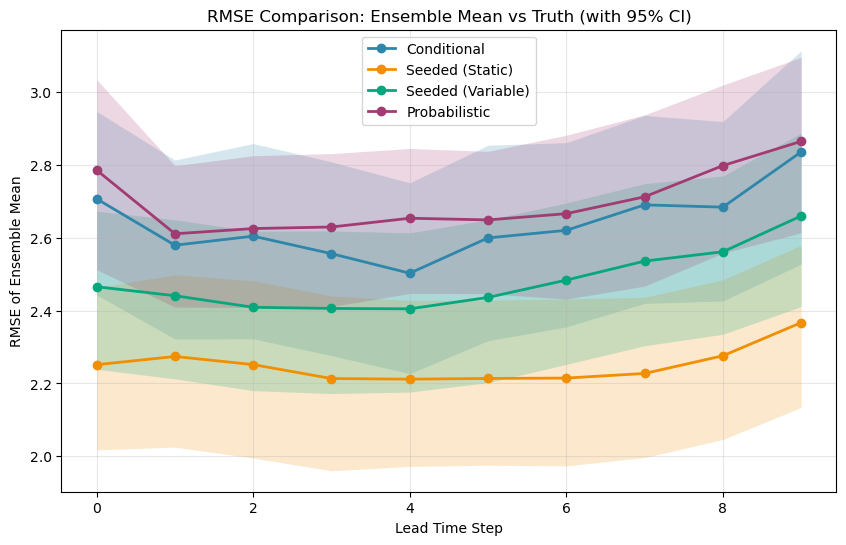

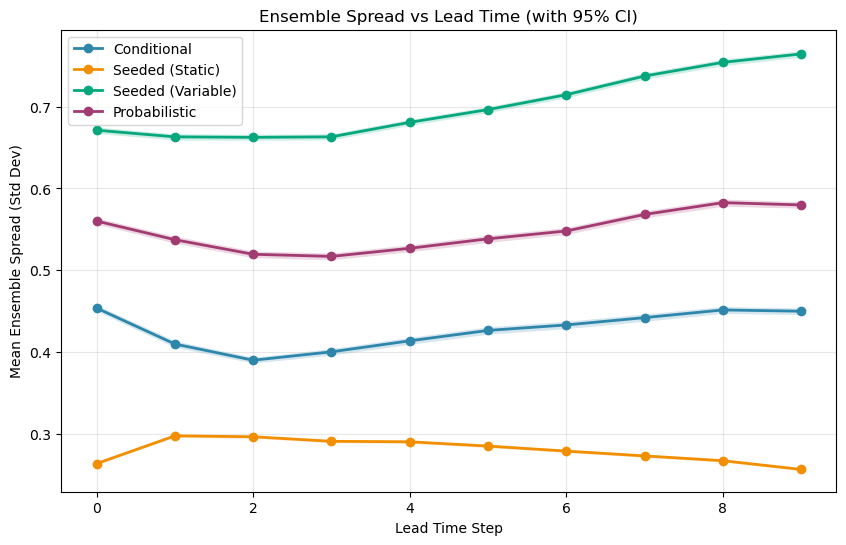

In [68]:
import matplotlib.pyplot as plt
import numpy as np

# Setup
models = ['Conditional', 'Seeded (Static)', 'Seeded (Variable)', 'Probabilistic']
colors = ['#2E86AB', '#F18F01', '#06A77D', '#A23B72']
model_colors = dict(zip(models, colors))

# 1. Prepare Ground Truth
# stored_forecasts['Discharge'] has shape (N, 11, 10)
truth = stored_forecasts['Discharge'][:, 0, :]
N = truth.shape[0] # Number of samples (approx 695k)

# ==========================================
# PLOT 1: RMSE Comparison with 95% CI
# ==========================================
plt.figure(figsize=(10, 6))

for model in models:
    # Get Data
    model_mean = ensemble_means[model]  # Shape (N, 10)
    
    # 1. Calculate Squared Errors
    squared_errors = (model_mean - truth) ** 2  # Shape (N, 10)
    
    # 2. Calculate MSE and Standard Error of MSE
    mse = np.mean(squared_errors, axis=0)       # Mean (10,)
    std_sq_err = np.std(squared_errors, axis=0) # Std Dev of SE (10,)
    se_mse = std_sq_err / np.sqrt(N)            # Standard Error (10,)
    
    # 3. Calculate 95% CI for MSE, then convert to RMSE
    # Bounds for MSE
    mse_lower = mse - 1.96 * se_mse
    mse_upper = mse + 1.96 * se_mse
    
    # Clip lower bound at 0 to avoid sqrt(negative)
    mse_lower = np.maximum(mse_lower, 0)
    
    # Convert to RMSE
    rmse = np.sqrt(mse)
    rmse_lower = np.sqrt(mse_lower)
    rmse_upper = np.sqrt(mse_upper)
    
    # 4. Plot Line
    lead_times = range(len(rmse))
    plt.plot(lead_times, rmse, 
             marker='o', linestyle='-', linewidth=2,
             color=model_colors[model], label=model)
    
    # 5. Plot Confidence Interval
    plt.fill_between(lead_times, rmse_lower, rmse_upper, 
                     color=model_colors[model], alpha=0.2, linewidth=0)

plt.xlabel('Lead Time Step')
plt.ylabel('RMSE of Ensemble Mean')
plt.title('RMSE Comparison: Ensemble Mean vs Truth (with 95% CI)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ==========================================
# PLOT 2: Ensemble Spread Comparison with 95% CI
# ==========================================
plt.figure(figsize=(10, 6))

for model in models:
    # Get Data
    spreads = ensemble_spreads[model] # Shape (N, 10)
    
    # 1. Calculate Mean Spread and Standard Error
    mean_spread = np.mean(spreads, axis=0)      # Mean (10,)
    std_spread = np.std(spreads, axis=0)        # Std Dev of spread distribution (10,)
    se_spread = std_spread / np.sqrt(N)         # Standard Error (10,)
    
    # 2. Calculate 95% CI
    ci_lower = mean_spread - 1.96 * se_spread
    ci_upper = mean_spread + 1.96 * se_spread
    
    # 3. Plot Line
    lead_times = range(len(mean_spread))
    plt.plot(lead_times, mean_spread, 
             marker='o', linestyle='-', linewidth=2,
             color=model_colors[model], label=model)
    
    # 4. Plot Confidence Interval
    plt.fill_between(lead_times, ci_lower, ci_upper, 
                     color=model_colors[model], alpha=0.2, linewidth=0)

plt.xlabel('Lead Time Step')
plt.ylabel('Mean Ensemble Spread (Std Dev)')
plt.title('Ensemble Spread vs Lead Time (with 95% CI)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [76]:
std_sq_err

array([615.74866, 429.74454, 463.60437, 467.8879 , 447.99295, 439.01013,
       508.19708, 540.3252 , 547.4767 , 584.56354], dtype=float32)

In [ ]:
# ==========================================
# PLOT 3: Per-sample Spread–Skill Scatter
# ==========================================

# Collect global limits
all_error = []
all_spread = []

for model in models:
    abs_error = np.abs(ensemble_means[model] - truth)  # (N, 10)
    spread = ensemble_spreads[model]                   # (N, 10)

    all_error.append(abs_error.flatten())
    all_spread.append(spread.flatten())

all_error = np.concatenate(all_error)
all_spread = np.concatenate(all_spread)

mask = (all_error > 0) & (all_spread > 0)

data_min = min(all_error[mask].min(), all_spread[mask].min()) * 0.8
data_max = max(all_error.max(), all_spread.max()) * 1.2

for model in models:
    plt.figure(figsize=(6, 6))

    abs_error = np.abs(ensemble_means[model] - truth).flatten()
    spread = ensemble_spreads[model].flatten()

    valid = (abs_error > 0) & (spread > 0)

    plt.scatter(
        abs_error[valid],
        spread[valid],
        s=1,
        alpha=0.05,
        color=model_colors[model],
        rasterized=True
    )

    # 1:1 line
    plt.plot(
        [data_min, data_max],
        [data_min, data_max],
        color='black',
        linewidth=2,
        label='Spread = Error'
    )

    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(data_min, data_max)
    plt.ylim(data_min, data_max)

    plt.xlabel('Absolute Error of Ensemble Mean')
    plt.ylabel('Ensemble Spread')
    plt.title(f'{model}: Per-sample Spread–Skill')
    plt.legend()
    plt.grid(True, which="both", alpha=0.3)
    plt.gca().set_aspect('equal', adjustable='box')

    plt.show()



In [62]:
# ==========================================
# PLOT 3: Spread–Skill Scatter (ECMWF-style)
# ==========================================

# Collect global limits from RMSE and spread
all_rmse = []
all_spread = []

for model in models:
    all_rmse.append(rmse_results[model])                       # (10,)
    all_spread.append(np.mean(ensemble_spreads[model], axis=0))# (10,)

all_rmse = np.concatenate(all_rmse)
all_spread = np.concatenate(all_spread)



In [33]:
means = pd.Series({key: variogram_scores[key].mean() for key in variogram_scores.keys()})
print(means)


Conditional          0.182684
NLL                       NaN
Seeded (Static)      0.207398
Seeded (Variable)    0.254466
Probabilistic        0.234703
dtype: float32


In [34]:
def flatten_batch_dict_of_lists(ensemble_summaries, nested_dicts=True, batch_dim = 1):
    """
    Flatten batch dimension in a dictionary of lists of tensors or dictionaries of tensors.

    Args:
        ensemble_summaries (dict): The input dictionary. Each value is a list of items,
                                   where each item is either a tensor or a dictionary of tensors.
        nested_dicts (bool): If True, expects each list item to be a dict of tensors.
                             If False, expects each list item to be a tensor.

    Returns:
        dict: A new dictionary with the batch dimension flattened into the list level.
    """
    new_ensemble = {}

    for key, lst in ensemble_summaries.items():
        new_list = []

        for entry in lst:
            if nested_dicts:
                batch_size = next(iter(entry.values())).shape[batch_dim]
                for i in range(batch_size):
                    new_entry = {k: v[..., i].clone() for k, v in entry.items()}
                    new_list.append(new_entry)
            else:
                batch_size = entry.shape[batch_dim]
                for i in range(batch_size):
                    new_list.append(entry.select(batch_dim, i).clone())

        new_ensemble[key] = new_list

    return new_ensemble

In [35]:
means_dict = {}
for key, array in crps_per_leadtime.items():
    means_dict[key] = np.nanmean(array, axis=0)

# Create DataFrame
df = pd.DataFrame(means_dict, index=[f'leadtime_{i}' for i in range(1, 11)])

df

,Conditional,Seeded (Static),Seeded (Variable),Probabilistic
leadtime_1,0.397148,0.443270,0.446353,0.437207
leadtime_2,0.379951,0.427684,0.439810,0.422031
leadtime_3,0.376806,0.423072,0.434001,0.416513
leadtime_4,0.373928,0.421355,0.433954,0.416809
leadtime_5,0.372566,0.424175,0.437643,0.417199
leadtime_6,0.377099,0.429721,0.444757,0.419893
leadtime_7,0.383674,0.435534,0.452324,0.423057
leadtime_8,0.392360,0.442591,0.461695,0.429014
leadtime_9,0.405333,0.455614,0.474279,0.441002
leadtime_10,0.426093,0.476772,0.493110,0.461055


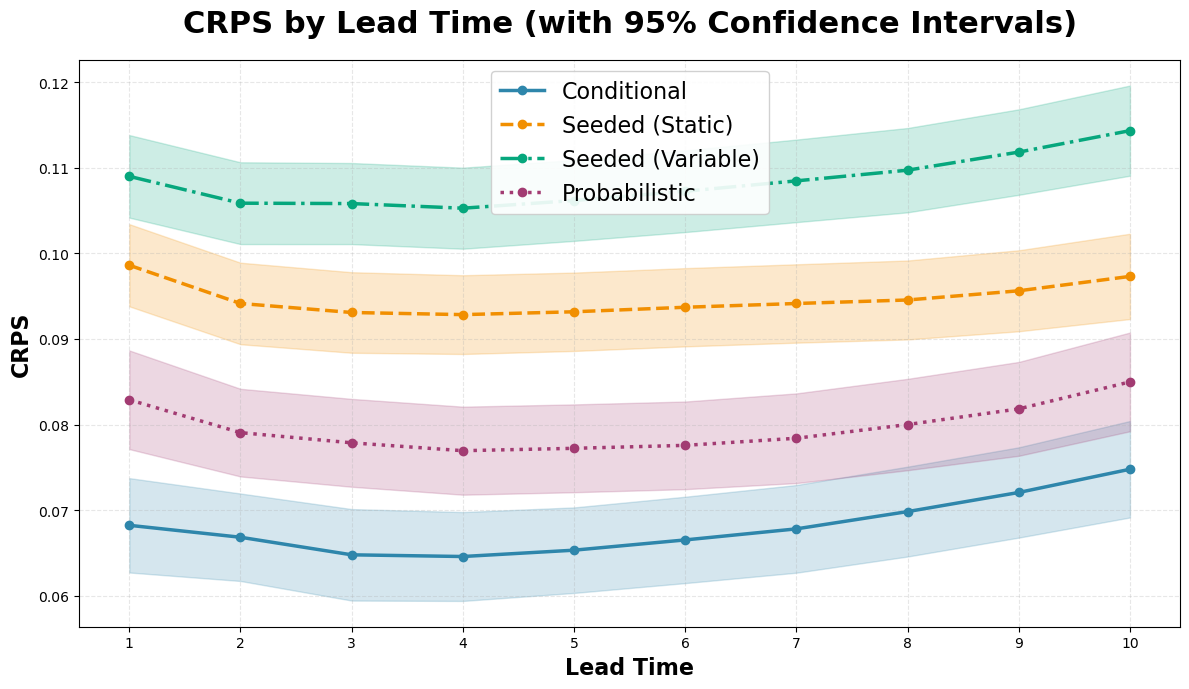

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Calculate statistics for each model
leadtimes = np.arange(1, 11)

fig, ax = plt.subplots(figsize=(12, 7))

models = ['Conditional', 'Seeded (Static)', 'Seeded (Variable)', 'Probabilistic']
colors = ['#2E86AB', '#F18F01', '#06A77D', '#A23B72']
linestyles = ['-', '--', '-.', ':']

confidence_level = 0.95  # 95% confidence interval

for idx, model in enumerate(models):
    data = crps_per_leadtime[model]  # shape: (n_samples, 10)

    # Calculate mean across samples (axis=0), ignoring NaNs
    mean_vals = np.nanmean(data, axis=0)
    mean_vals = np.nanmedian(data, axis=0)
    
    # Calculate confidence intervals for each leadtime
    ci_lower = np.zeros(len(leadtimes))
    ci_upper = np.zeros(len(leadtimes))
    
    for i in range(len(leadtimes)):
        # Get data for this leadtime, removing NaNs
        leadtime_data = data[:, i]
        leadtime_data = leadtime_data[~np.isnan(leadtime_data)]
        
        if len(leadtime_data) > 1:
            # Calculate standard error
            sem = stats.sem(leadtime_data)
            n = len(leadtime_data)
            
            # Get t-critical value
            t_critical = stats.t.ppf(1 - (1-confidence_level)/2, df=n-1)
            
            # Calculate margin of error
            margin = t_critical * sem
            
            ci_lower[i] = mean_vals[i] - margin
            ci_upper[i] = mean_vals[i] + margin
        else:
            # Not enough data for CI
            ci_lower[i] = mean_vals[i]
            ci_upper[i] = mean_vals[i]
    
    # Plot confidence interval as shaded region
    ax.fill_between(leadtimes, ci_lower, ci_upper, 
                     color=colors[idx], alpha=0.2)
    
    # Plot mean line
    ax.plot(leadtimes, mean_vals, 
            color=colors[idx], 
            linestyle=linestyles[idx],
            linewidth=2.5, 
            label=model,
            marker='o',
            markersize=6)

ax.set_xlabel('Lead Time', fontsize=16, fontweight='bold')
ax.set_ylabel('CRPS', fontsize=16, fontweight='bold')
ax.set_title('CRPS by Lead Time (with 95% Confidence Intervals)', 
             fontsize=22, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=16, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xticks(leadtimes)

plt.tight_layout()
plt.show()

Lead times: [ 1  2  3  4  5  6  7  8  9 10]

Processing 4 models...
Confidence level: 0.95

Processing model 1/4: Conditional
Data shape: (695505, 10)
Data type: float32
Number of NaNs: 0
Data range: [0.0000, 585.3255]
Mean values: [0.39714825 0.37995145 0.3768055  0.37392765 0.3725659  0.3770987
 0.38367432 0.39236    0.4053325  0.42609274]

  Lead time 1:
    Valid samples: 695505
    Mean: 0.3971
    SEM: 0.0028
    t-critical: 1.9600
    Margin: 0.0055
    CI: [0.3916, 0.4027]

  Lead time 2:
    Valid samples: 695505
    Mean: 0.3800
    SEM: 0.0026
    t-critical: 1.9600
    Margin: 0.0051
    CI: [0.3748, 0.3851]

  Lead time 3:
    Valid samples: 695505
    Mean: 0.3768
    SEM: 0.0027
    t-critical: 1.9600
    Margin: 0.0053
    CI: [0.3715, 0.3822]

  Lead time 4:
    Valid samples: 695505
    Mean: 0.3739
    SEM: 0.0026
    t-critical: 1.9600
    Margin: 0.0052
    CI: [0.3687, 0.3791]

  Lead time 5:
    Valid samples: 695505
    Mean: 0.3726
    SEM: 0.0025
    t-critica

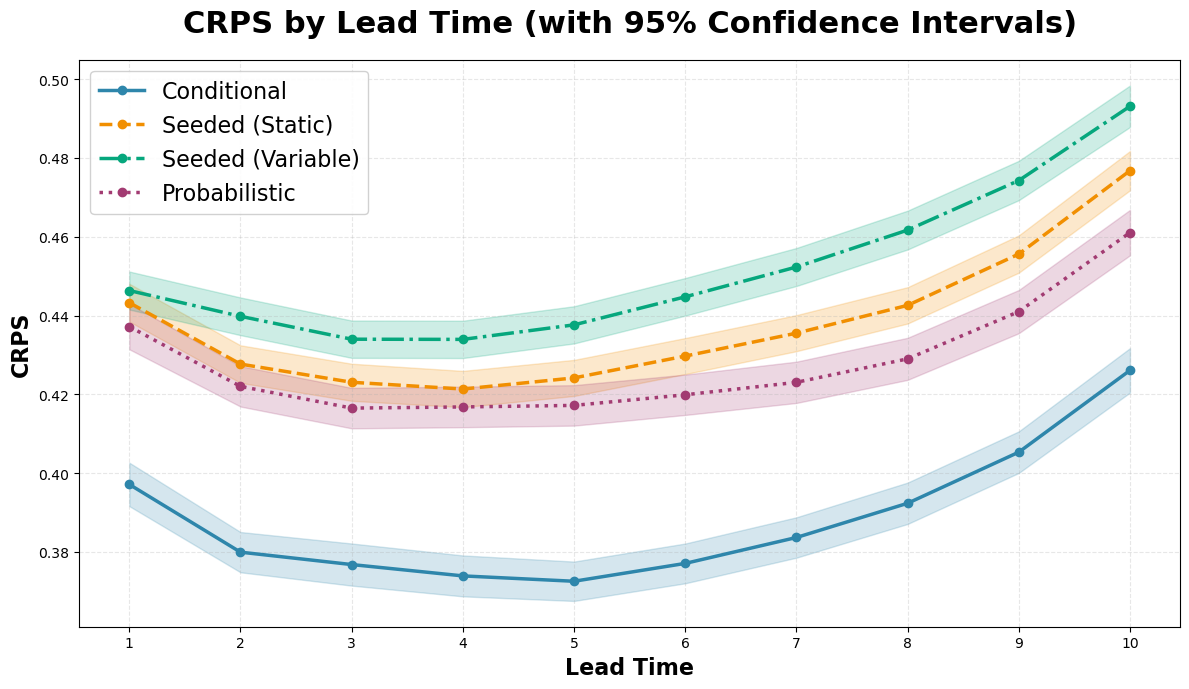

Done!


In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Calculate statistics for each model
leadtimes = np.arange(1, 11)
print(f"Lead times: {leadtimes}")

fig, ax = plt.subplots(figsize=(12, 7))
models = ['Conditional', 'Seeded (Static)', 'Seeded (Variable)', 'Probabilistic']
colors = ['#2E86AB', '#F18F01', '#06A77D', '#A23B72']
linestyles = ['-', '--', '-.', ':']
confidence_level = 0.95  # 95% confidence interval

print(f"\nProcessing {len(models)} models...")
print(f"Confidence level: {confidence_level}")

for idx, model in enumerate(models):
    print(f"\n{'='*60}")
    print(f"Processing model {idx+1}/{len(models)}: {model}")
    print(f"{'='*60}")
    
    data = crps_per_leadtime[model]  # shape: (n_samples, 10)
    print(f"Data shape: {data.shape}")
    print(f"Data type: {data.dtype}")
    print(f"Number of NaNs: {np.sum(np.isnan(data))}")
    print(f"Data range: [{np.nanmin(data):.4f}, {np.nanmax(data):.4f}]")
    
    # Calculate mean across samples (axis=0), ignoring NaNs
    mean_vals = np.nanmean(data, axis=0)
    print(f"Mean values: {mean_vals}")
    
    # Calculate confidence intervals for each leadtime
    ci_lower = np.zeros(len(leadtimes))
    ci_upper = np.zeros(len(leadtimes))
    
    for i in range(len(leadtimes)):
        # Get data for this leadtime, removing NaNs
        leadtime_data = data[:, i]
        leadtime_data = leadtime_data[~np.isnan(leadtime_data)]
        
        print(f"\n  Lead time {leadtimes[i]}:")
        print(f"    Valid samples: {len(leadtime_data)}")
        
        if len(leadtime_data) > 1:
            # Calculate standard error
            sem = stats.sem(leadtime_data)
            n = len(leadtime_data)
            
            # Get t-critical value
            t_critical = stats.t.ppf(1 - (1-confidence_level)/2, df=n-1)
            
            # Calculate margin of error
            margin = t_critical * sem
            
            ci_lower[i] = mean_vals[i] - margin
            ci_upper[i] = mean_vals[i] + margin
            
            print(f"    Mean: {mean_vals[i]:.4f}")
            print(f"    SEM: {sem:.4f}")
            print(f"    t-critical: {t_critical:.4f}")
            print(f"    Margin: {margin:.4f}")
            print(f"    CI: [{ci_lower[i]:.4f}, {ci_upper[i]:.4f}]")
        else:
            # Not enough data for CI
            ci_lower[i] = mean_vals[i]
            ci_upper[i] = mean_vals[i]
            print(f"    WARNING: Not enough data for CI (n={len(leadtime_data)})")
    
    print(f"\nFinal CI lower: {ci_lower}")
    print(f"Final CI upper: {ci_upper}")
    
    # Plot confidence interval as shaded region
    ax.fill_between(leadtimes, ci_lower, ci_upper, 
                     color=colors[idx], alpha=0.2)
    
    # Plot mean line
    ax.plot(leadtimes, mean_vals, 
            color=colors[idx], 
            linestyle=linestyles[idx],
            linewidth=2.5, 
            label=model,
            marker='o',
            markersize=6)
    
    print(f"✓ Successfully plotted {model}")

print(f"\n{'='*60}")
print("Setting up plot formatting...")
ax.set_xlabel('Lead Time', fontsize=16, fontweight='bold')
ax.set_ylabel('CRPS', fontsize=16, fontweight='bold')
ax.set_title('CRPS by Lead Time (with 95% Confidence Intervals)', 
             fontsize=22, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=16, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xticks(leadtimes)
plt.tight_layout()
print("Displaying plot...")
plt.show()
print("Done!")

In [38]:
import numpy as np
import pandas as pd

# Define CRPS intervals
intervals = [(0, 0.1), (0.1, 1), (1, 10), (10, np.inf)]
interval_labels = ['0-0.1', '0.1-1', '1-10', '10+']

print("CRPS Distribution Across Models")
print("="*80)

# Create a dictionary to store results
results = {}

for model in models:
    data = crps_per_leadtime[model]  # shape: (n_samples, 10)
    
    # Flatten to get all CRPS values for this model
    all_crps = data.flatten()
    
    # Remove NaNs
    all_crps = all_crps[~np.isnan(all_crps)]
    
    total_count = len(all_crps)
    
    print(f"\n{model}:")
    print(f"  Total predictions: {total_count}")
    
    # Count how many fall in each interval
    counts = []
    percentages = []
    
    for (lower, upper), label in zip(intervals, interval_labels):
        if upper == np.inf:
            count = np.sum(all_crps >= lower)
        else:
            count = np.sum((all_crps >= lower) & (all_crps < upper))
        
        pct = (count / total_count * 100) if total_count > 0 else 0
        counts.append(count)
        percentages.append(pct)
        
        print(f"  {label:>10}: {count:6d} ({pct:5.1f}%)")
    
    results[model] = {
        'counts': counts,
        'percentages': percentages,
        'total': total_count
    }

# Create a nice summary table
print("\n" + "="*80)
print("\nSUMMARY TABLE (Counts)")
print("-"*80)

# Create DataFrame for counts
count_data = {model: results[model]['counts'] for model in models}
count_df = pd.DataFrame(count_data, index=interval_labels)
print(count_df.to_string())

print("\n" + "-"*80)
print("\nSUMMARY TABLE (Percentages)")
print("-"*80)

# Create DataFrame for percentages
pct_data = {model: [f"{p:.1f}%" for p in results[model]['percentages']] for model in models}
pct_df = pd.DataFrame(pct_data, index=interval_labels)
print(pct_df.to_string())
# Additional analysis: mean CRPS per interval
print("\n" + "="*80)
print("\nMEAN CRPS WITHIN EACH INTERVAL (per model)")
print("-"*80)

for model in models:
    data = crps_per_leadtime[model]
    all_crps = data.flatten()
    all_crps = all_crps[~np.isnan(all_crps)]
    
    # Calculate overall mean CRPS for this model
    overall_mean = np.mean(all_crps)
    total_count = len(all_crps)
    
    print(f"\n{model}:")
    print(f"  Overall mean CRPS: {overall_mean:.2f}")
    print(f"  Total predictions: {total_count}")
    print(f"  {'Interval':>10} | {'Mean':>8} | {'Count':>6} | {'% of total':>10} | {'Contribution':>12}")
    print(f"  {'-'*10}-+-{'-'*8}-+-{'-'*6}-+-{'-'*10}-+-{'-'*12}")
    
    total_contribution = 0
    
    for (lower, upper), label in zip(intervals, interval_labels):
        if upper == np.inf:
            interval_data = all_crps[all_crps >= lower]
        else:
            interval_data = all_crps[(all_crps >= lower) & (all_crps < upper)]
        
        if len(interval_data) > 0:
            mean_crps = np.mean(interval_data)
            count = len(interval_data)
            percentage = (count / total_count) * 100
            
            # Calculate contribution to overall mean
            # Contribution = (count / total_count) * mean_of_interval
            contribution = (count / total_count) * mean_crps
            total_contribution += contribution
            
            print(f"  {label:>10} | {mean_crps:8.2f} | {count:6d} | {percentage:9.1f}% | {contribution:12.2f}")
        else:
            print(f"  {label:>10} | {'no data':>8} | {0:6d} | {0:9.1f}% | {0:12.2f}")
    
    print(f"  {'-'*10}-+-{'-'*8}-+-{'-'*6}-+-{'-'*10}-+-{'-'*12}")
    print(f"  {'TOTAL':>10} | {overall_mean:8.2f} | {total_count:6d} | {100.0:9.1f}% | {total_contribution:12.2f}")
    
    # Verification check
    if abs(total_contribution - overall_mean) > 0.01:
        print(f"  WARNING: Contribution sum ({total_contribution:.2f}) doesn't match overall mean ({overall_mean:.2f})")


# Check if best model is really better at high-error cases
print("\n" + "="*80)
print("\nHYPOTHESIS CHECK: Does your best model perform relatively better at high errors?")
print("-"*80)

for (lower, upper), label in zip(intervals, interval_labels):
    print(f"\n{label} interval:")
    
    interval_means = {}
    interval_contributions = {}
    
    for model in models:
        data = crps_per_leadtime[model]
        all_crps = data.flatten()
        all_crps = all_crps[~np.isnan(all_crps)]
        total_count = len(all_crps)
        
        if upper == np.inf:
            interval_data = all_crps[all_crps >= lower]
        else:
            interval_data = all_crps[(all_crps >= lower) & (all_crps < upper)]
        
        if len(interval_data) > 0:
            interval_means[model] = np.mean(interval_data)
            interval_contributions[model] = (len(interval_data) / total_count) * interval_means[model]
        else:
            interval_means[model] = np.nan
            interval_contributions[model] = 0
    
    # Sort models by performance in this interval
    sorted_models = sorted(interval_means.items(), key=lambda x: x[1] if not np.isnan(x[1]) else np.inf)
    
    for rank, (model, mean_val) in enumerate(sorted_models, 1):
        if not np.isnan(mean_val):
            contrib = interval_contributions[model]
            print(f"  {rank}. {model:25s}: mean = {mean_val:8.2f}, contribution = {contrib:8.2f}")

# Summary: Which interval contributes most to each model's overall CRPS?
print("\n" + "="*80)
print("\nWHICH INTERVAL CONTRIBUTES MOST TO OVERALL CRPS?")
print("-"*80)

for model in models:
    data = crps_per_leadtime[model]
    all_crps = data.flatten()
    all_crps = all_crps[~np.isnan(all_crps)]
    total_count = len(all_crps)
    
    contributions = []
    
    for (lower, upper), label in zip(intervals, interval_labels):
        if upper == np.inf:
            interval_data = all_crps[all_crps >= lower]
        else:
            interval_data = all_crps[(all_crps >= lower) & (all_crps < upper)]
        
        if len(interval_data) > 0:
            mean_crps = np.mean(interval_data)
            contribution = (len(interval_data) / total_count) * mean_crps
            contributions.append((label, contribution))
        else:
            contributions.append((label, 0))
    
    # Sort by contribution
    contributions.sort(key=lambda x: x[1], reverse=True)
    
    print(f"\n{model}:")
    for rank, (label, contrib) in enumerate(contributions, 1):
        pct_of_total = (contrib / np.mean(all_crps)) * 100 if np.mean(all_crps) > 0 else 0
        print(f"  {rank}. {label:>10}: {contrib:8.2f} ({pct_of_total:5.1f}% of total CRPS)")
        


CRPS Distribution Across Models

Conditional:
  Total predictions: 6955050
       0-0.1: 4110042 ( 59.1%)
       0.1-1: 2345405 ( 33.7%)
        1-10: 472361 (  6.8%)
         10+:  27242 (  0.4%)

Seeded (Static):
  Total predictions: 6955050
       0-0.1: 3561418 ( 51.2%)
       0.1-1: 2799881 ( 40.3%)
        1-10: 564973 (  8.1%)
         10+:  28778 (  0.4%)

Seeded (Variable):
  Total predictions: 6955050
       0-0.1: 3329689 ( 47.9%)
       0.1-1: 3032932 ( 43.6%)
        1-10: 561460 (  8.1%)
         10+:  30969 (  0.4%)

Probabilistic:
  Total predictions: 6955050
       0-0.1: 3857938 ( 55.5%)
       0.1-1: 2540425 ( 36.5%)
        1-10: 525514 (  7.6%)
         10+:  31173 (  0.4%)


SUMMARY TABLE (Counts)
--------------------------------------------------------------------------------
       Conditional  Seeded (Static)  Seeded (Variable)  Probabilistic
0-0.1      4110042          3561418            3329689        3857938
0.1-1      2345405          2799881            303

In [9]:
# Extract catchment IDs from metadata
catchments = np.array(metadata['basin_idx'])  # Keep as string array

# Find boundaries where catchment changes
change_points = np.where(catchments[:-1] != catchments[1:])[0] + 1
boundaries = np.concatenate([[0], change_points, [len(catchments)]])

# Get unique catchments in order of appearance
unique_catchments = [catchments[boundaries[i]] for i in range(len(boundaries) - 1)]

# Models to process


# Create results more efficiently
results = []

for model in models:
    data = crps_per_leadtime[model]  # shape: (200000, 10)
    
    for catchment_idx, catchment in enumerate(unique_catchments):
        start = boundaries[catchment_idx]
        end = boundaries[catchment_idx + 1]
        
        # Extract all leadtimes for this catchment at once
        catchment_data = data[start:end, :]  # shape: (n_samples, 10)
        
        # Calculate mean for all leadtimes at once
        mean_crps = np.nanmean(catchment_data, axis=0)
        counts = np.sum(~np.isnan(catchment_data), axis=0)
        
        # Add results for all leadtimes
        for leadtime in range(1, 11):
            results.append({
                'model': model,
                'catchment': catchment,
                'leadtime': leadtime,
                'mean_crps': mean_crps[leadtime - 1],
                'n_samples': counts[leadtime - 1]
            })

# Create DataFrame
df_catchment = pd.DataFrame(results)

# Pivot to get leadtimes as columns
df_pivot = df_catchment.pivot_table(
    index=['model', 'catchment'],
    columns='leadtime',
    values='mean_crps'
)
df_pivot.columns = [f'leadtime_{i}' for i in df_pivot.columns]
df_pivot = df_pivot.reset_index()

print("Long format DataFrame shape:", df_catchment.shape)


Long format DataFrame shape: (27960, 5)


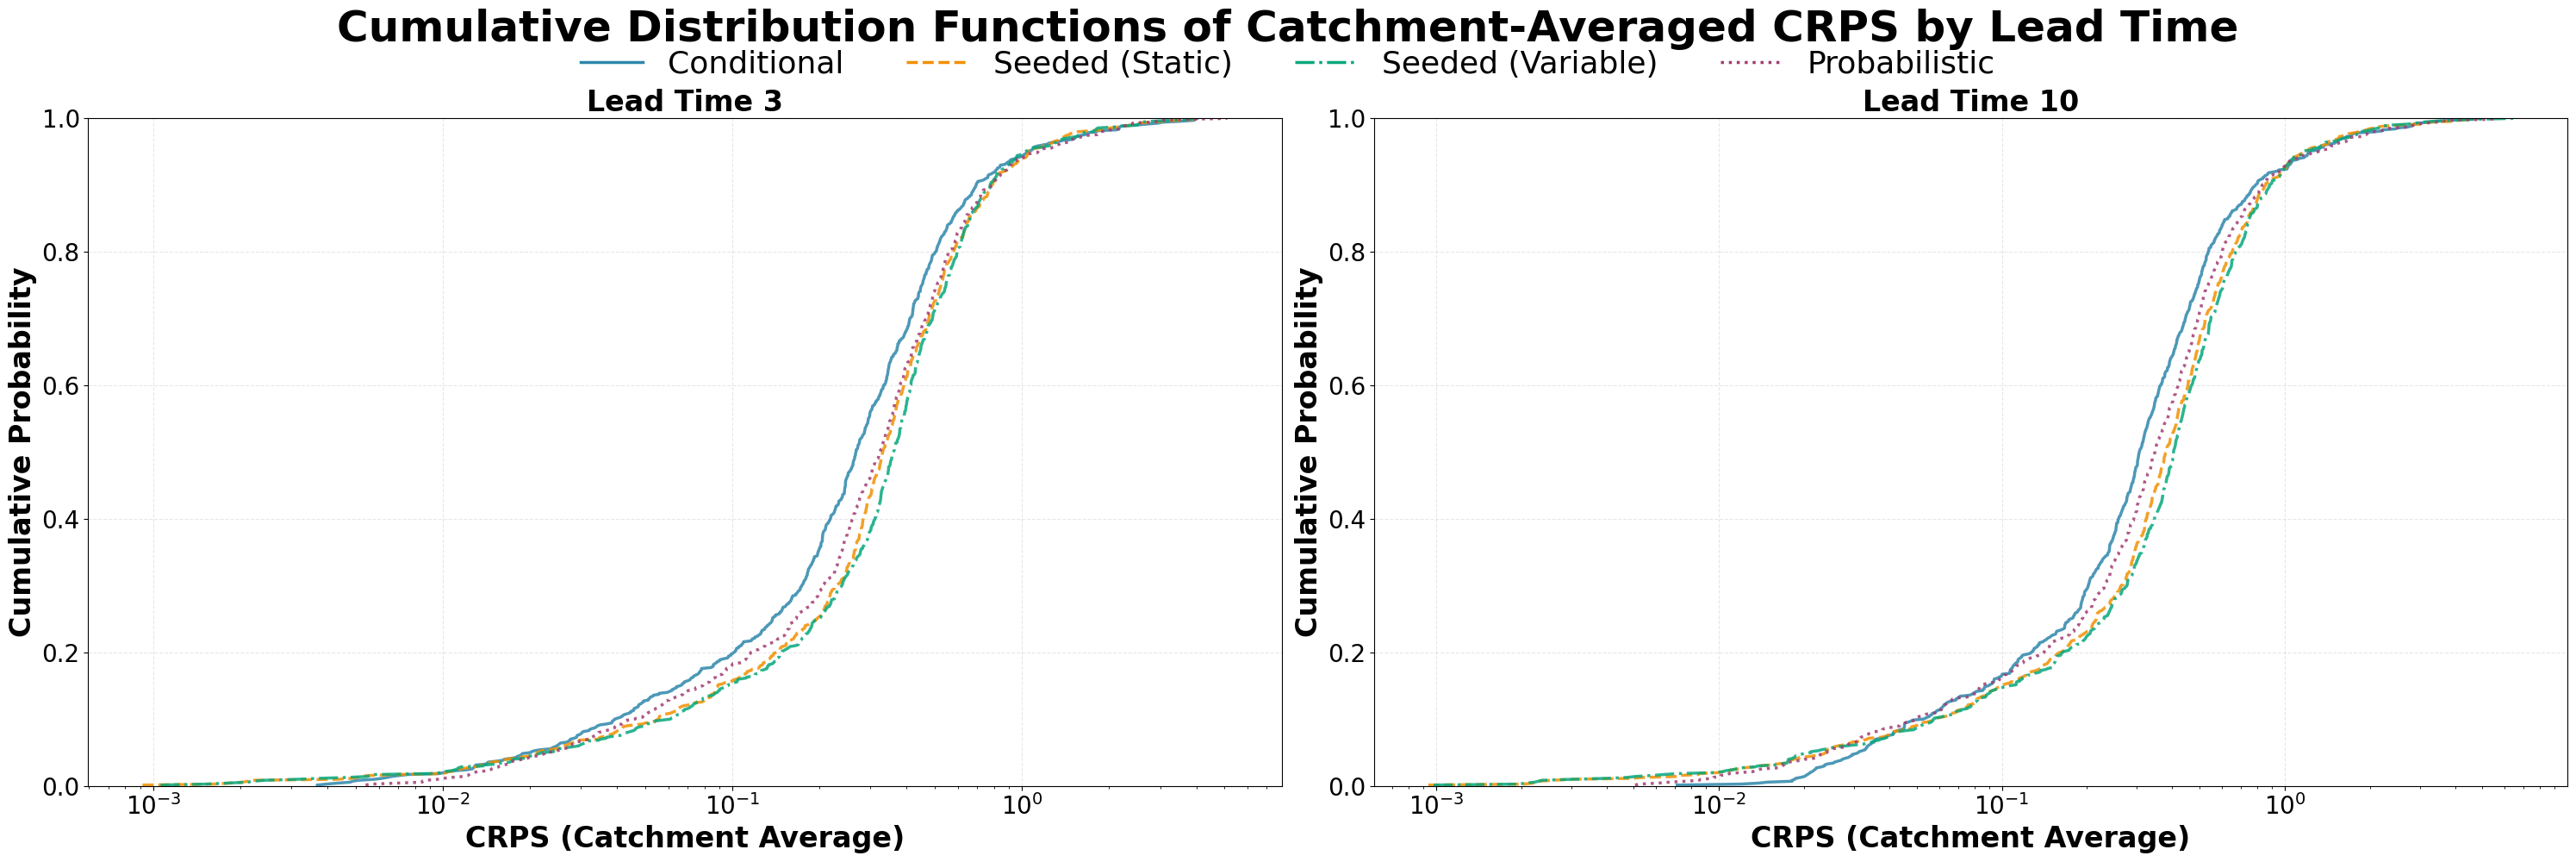

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# Models to plot

leadtimes = np.arange(1, 11)

# Create subplots - one for each leadtime
fig, axes = plt.subplots(1, 2, figsize=(30, 10))
axes = axes.flatten()

colors = ['#2E86AB', '#F18F01', '#06A77D', '#A23B72']
linestyles = ['-', '--', '-.', ':']
linewidth = 2.5

for lt_idx, ax in enumerate(axes):
    leadtimes = [3, 10]
    leadtime = leadtimes[lt_idx]
    
    for model_idx, model in enumerate(models):
        # Get catchment-averaged CRPS for this model and leadtime
        model_data = df_pivot[df_pivot['model'] == model]
        col = f'leadtime_{leadtime}'
        data = model_data[col].dropna().values
        
        if len(data) > 0:
            # Sort data for CDF
            sorted_data = np.sort(data)
            # Calculate cumulative probabilities
            cum_prob = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
            
            ax.plot(sorted_data, cum_prob,
                   color=colors[model_idx],
                   linestyle=linestyles[model_idx],
                   linewidth=linewidth,
                   alpha=0.85)
    
    ax.set_xlabel('CRPS (Catchment Average)', fontsize=24, fontweight='bold')
    ax.set_ylabel('Cumulative Probability', fontsize=24, fontweight='bold')
    ax.set_title(f'Lead Time {leadtime}', fontsize=24, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_ylim(0, 1)
    ax.set_xscale('log')
    
    # Make tick labels bigger
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=16)

# Create custom legend elements
legend_elements = [Line2D([0], [0], color=colors[i], linestyle=linestyles[i], 
                          linewidth=linewidth, label=models[i]) 
                   for i in range(len(models))]

# Add legend at the top of the figure
fig.legend(handles=legend_elements, loc='upper center', ncol=4, 
          frameon=False, fontsize=26, bbox_to_anchor=(0.5, 0.98))

plt.suptitle('Cumulative Distribution Functions of Catchment-Averaged CRPS by Lead Time', 
             fontsize=36, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.98])  # Leave space at top for legend
plt.show()


# KGE

In [11]:
stacked_basin_forecasts = {}
for basin_id, model_dict in basin_forecasts.items():
    stacked_basin_forecasts[basin_id[0]] = {}
    for model, forecasts in model_dict.items():
        if forecasts:  # Check if there are any forecasts for this basin-model combination
            try:
                stacked_basin_forecasts[basin_id[0]][model] = torch.stack(forecasts)
            except:
                # In case of inconsistent tensor shapes, we can handle it gracefully
                print(f"Warning: Could not stack forecasts for basin {basin_id}, model {model} due to shape inconsistency")
                stacked_basin_forecasts[basin_id][model] = forecasts  # Keep the list version


NameError: name 'basin_forecasts' is not defined

In [ ]:
leadtimes = list(range(10))

In [ ]:
KGE = defaultdict(dict)
for basin in stacked_basin_forecasts.keys():
    for model in stacked_basin_forecasts[basin].keys():
        if model != 'Discharge':
            forecasts = stacked_basin_forecasts[basin][model].mean(axis = 1)  # shape: (n_members, n_leadtimes)
            discharge = stacked_basin_forecasts[basin]['Discharge']  # shape: (n_leadtimes,)
            KGE[basin, model] = [
                compute_kge(discharge[:, leadtime], forecasts[:, leadtime])
                for leadtime in leadtimes
            ]

In [ ]:
KGE_df = pd.DataFrame.from_dict(KGE, orient='index')  # index = (basin, model), columns = leadtimes
KGE_df = KGE_df[KGE_df.index.map(lambda x: isinstance(x, tuple))]

KGE_df.index = pd.MultiIndex.from_tuples(KGE_df.index, names=['Basin', 'Model'])

KGE_mean_per_day = KGE_df.groupby('Model').mean()
KGE_mean_per_day

In [ ]:
def calculate_kge_by_leadtime_model_basin(stacked_basin_forecasts, models=None, num_leadtimes=10):
    """
    Calculate KGE scores for each leadtime, model, and basin
    
    Parameters:
    -----------
    stacked_basin_forecasts : dict
        Dictionary of stacked forecasts by basin and model
    models : list, optional
        List of model names to process. If None, all models except 'Discharge' will be used.
    num_leadtimes : int, optional
        Number of leadtimes to process. If None, determined from the first basin/model.
        
    Returns:
    --------
    dict
        Dictionary with structure {basin_id: {model: {leadtime: kge_score}}}
    """
    # Default to all models except Discharge if not specified
    if models is None:
        # Get all models from the first basin and exclude 'Discharge'
        first_basin = list(stacked_basin_forecasts.keys())[0]
        all_models = list(stacked_basin_forecasts[first_basin].keys())
        models = [model for model in all_models if model != 'Discharge']

    # Initialize the result dictionary
    kge_scores = {}
    
    # Iterate through each basin
    for basin_id, basin_data in stacked_basin_forecasts.items():
        kge_scores[basin_id] = {}
        
        # Skip if Discharge is not available for this basin
        if 'Discharge' not in basin_data:
            print(f"Warning: Basin {basin_id} has no Discharge data. Skipping.")
            continue
        
        discharge_data = basin_data['Discharge']
        
        # Process each model
        for model in models:
            if model not in basin_data:
                print(f"Warning: Model {model} not available for basin {basin_id}. Skipping.")
                continue
            
            model_data = basin_data[model]
            kge_scores[basin_id][model] = {}
            
            # Process each leadtime
            for leadtime in range(num_leadtimes):
                try:
                    # Extract the data for this leadtime
                    if isinstance(discharge_data, torch.Tensor) and isinstance(model_data, torch.Tensor):
                        # Stacked tensors case
                        # For discharge: shape [num_samples, num_leadtimes]
                        # For model forecasts: shape [num_samples, num_leadtimes] or [num_members, num_samples, num_leadtimes]
                        
                        # Extract discharge data for this leadtime
                        discharge_leadtime = discharge_data[:, leadtime]
                        
                        # Extract model data for this leadtime
                        if len(model_data.shape) == 3:  # [num_members, num_samples, num_leadtimes]
                            # Take mean across ensemble members
                            model_leadtime = model_data[:, :, leadtime].mean(dim=0)
                        elif len(model_data.shape) == 2:  # [num_samples, num_leadtimes]
                            model_leadtime = model_data[:, leadtime]
                        else:
                            raise ValueError(f"Unexpected shape for {model} data: {model_data.shape}")
                        
                        # Compute KGE
                        kge = compute_kge(discharge_leadtime, model_leadtime)
                        kge_scores[basin_id][model][leadtime] = kge
                    else:
                        # Handle non-stacked case (list of tensors)
                        # This is more complex and would need custom handling
                        print(f"Warning: Non-stacked tensors for basin {basin_id}, model {model}. Skipping.")
                except Exception as e:
                    print(f"Error calculating KGE for basin {basin_id}, model {model}, leadtime {leadtime}: {e}")
                    kge_scores[basin_id][model][leadtime] = None
    
    return kge_scores


# Getting hydrographs over 3 years

In [43]:
stacked_forecasts = {key: torch.stack(val) for key, val in stored_forecasts.items()}

In [44]:
date_string = dates[165][0]
date_string

'2018-01-07 00:00:00'

In [51]:
import matplotlib.pyplot as plt
import torch
from ipywidgets import interact, IntSlider
from datetime import datetime, timedelta


start_idx = 165
length = 365
leadtime = 10
date_string = dates[start_idx][0]
initial_date = datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S')
start_day = initial_date + timedelta(days=leadtime)


# Helper function to plot based on lead_time
def plot_forecast_vs_observed(forecasts, observations, location, model, lead_time_idx = 0, start_day = start_day):
    plt.figure(figsize=(20, 10))



    start_day = pd.to_datetime(start_day)
    date_range = pd.date_range(start=start_day, periods=length, freq='D')

    observed = [true[lead_time_idx].item() for true in observations][start_idx: start_idx + length]
    forecast_mean = [ens[:, lead_time_idx].mean().item() for ens in forecasts][start_idx: start_idx + length]
    forecast_min = [ens[:, lead_time_idx].min().item() for ens in forecasts][start_idx: start_idx + length]
    forecast_max = [ens[:, lead_time_idx].max().item() for ens in forecasts][start_idx: start_idx + length]

    nse = compute_nse(observed, forecast_mean)
    kge = compute_kge(observed, forecast_mean)
    
    # Observed
    plt.plot(date_range, observed, color='black', label='Observed')

    # Forecast mean
    plt.plot(date_range,forecast_mean, color='blue', label='Forecast (mean)')

    # Forecast range
    plt.fill_between(
        date_range,
        forecast_min,
        forecast_max,
        color='blue',
        alpha=0.2,
        label='Forecast Range'
    )

    # Formatting x-axis ticks
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

    plt.xlabel("Forecast Day", fontsize=20)
    plt.ylabel("Specific Discharge ($ms^{-1}$)", fontsize=20)
    plt.xticks(rotation=45, fontsize=16)
    plt.yticks(fontsize=16)
        
    plt.title(
        f"{model} Model: {location} Forecast vs Observed Specific Discharge - {lead_time_idx + 1} Days Ahead \n"
        f"NSE = {nse:.3f}, KGE = {kge:.3f}", fontsize=22
    )
    plt.legend(fontsize=20)
    plt.grid(True)
    plt.tight_layout()

    plt.show()



In [ ]:
# Create the interactive slider
model = 'CRPS'
interact(lambda i: plot_forecast_vs_observed(stacked_forecasts[f'{model}'].squeeze(), stacked_forecasts['Discharge'].squeeze(), location = 'Hysets 11477000' , model = f'{model}', lead_time_idx=i), i=(0, stacked_forecasts[f'{model}'].shape[-1]-1))

In [ ]:
location = 'Hysets_11477000'

for model in stacked_forecasts:
    if model == 'Discharge':
        continue  # skip the true observations

    print(f"Interactive plot for model: {model}")
    
    interact(
        lambda i, model=model: plot_forecast_vs_observed(
            stacked_forecasts[model].squeeze(),
            stacked_forecasts['Discharge'].squeeze(),
            location=location,
            model=model,
            lead_time_idx=i
        ),
        i=(0, stacked_forecasts[model].shape[-1] - 1)
        # i=(0, stacked_forecasts[model].shape[-1] - 1)
    )

In [48]:
avg_per_model = {
    model: [float(f"{x:.3g}") for x in torch.stack(tensors).mean(dim=0).squeeze().tolist()]
    for model, tensors in crps_per_leadtime.items()
}

# Create a DataFrame
lead_times = [f'Lead {i+1}' for i in range(10)]
df = pd.DataFrame(avg_per_model, index=lead_times).T  # Transpose for models as rows
df.index.name = 'Model'
df.columns.name = 'Lead Time'

model_name_mapping = {
    'CRPS': 'Conditional-LSTM',
    'Fixed_Seeded': 'Static-Seeded-LSTM',
    'Non_Fixed_Seeded': 'Random-Seeded-LSTM',
    'NonBinary': 'Probabilistic-LSTM'
}

df.index = df.index.map(lambda x: model_name_mapping.get(x, x))
df.index.name = 'Model'

df

Lead Time,Lead 1,Lead 2,Lead 3,Lead 4,Lead 5,Lead 6,Lead 7,Lead 8,Lead 9,Lead 10
Model,,,,,,,,,,
Conditional-LSTM,0.375,0.363,0.384,0.429,0.410,0.385,0.385,0.394,0.423,0.396
NLL,0.373,0.350,0.399,0.426,0.404,0.374,0.362,0.377,0.421,0.392
Static-Seeded-LSTM,0.387,0.377,0.442,0.432,0.405,0.428,0.421,0.432,0.486,0.422
Random-Seeded-LSTM,0.393,0.372,0.414,0.421,0.396,0.374,0.390,0.399,0.439,0.401
Probabilistic-LSTM,0.437,0.399,0.444,0.425,0.425,0.419,0.402,0.437,0.469,0.409


In [53]:
np.mean(variogram_scores['CRPS'])


np.float32(7.32129)

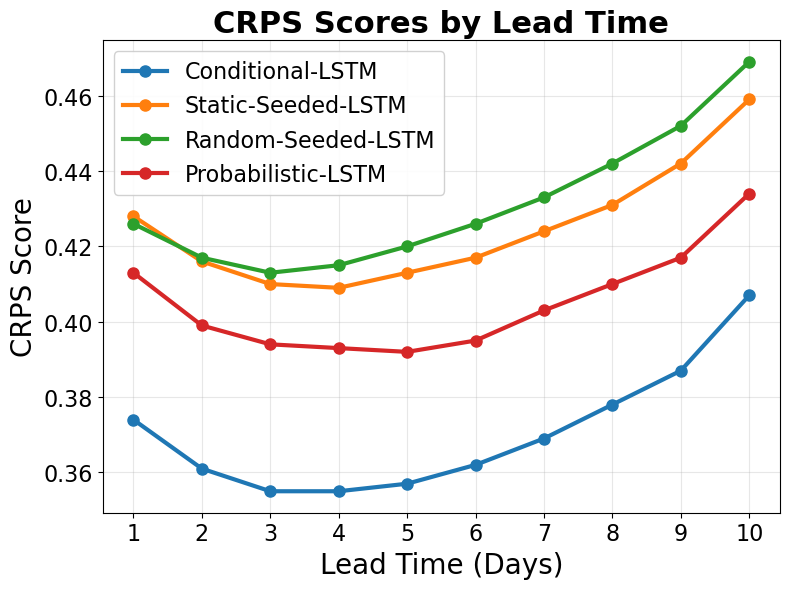

In [43]:

# Create the line plot
plt.figure(figsize=(8, 6))

# Plot each model as a line
for model in df.index:
    plt.plot(range(1, 11), df.loc[model], marker='o', linewidth=3, markersize=8, label=model)

plt.xlabel('Lead Time (Days)', fontsize=20)
plt.ylabel('CRPS Score', fontsize=20)
plt.title('CRPS Scores by Lead Time', fontsize=22, fontweight='bold')
plt.legend(fontsize=16, framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.xticks(range(1, 11), fontsize=16)
plt.yticks(fontsize=16)

# Optional: Add some styling
plt.tight_layout()

# Show the plot
plt.show()

total_flow        34.8357
variance          49.1062
gamma             47.2922
autoregression     1.1546
num_rise          31.4141
fdc_curve         38.3878
Name: 0, dtype: float64

# Recording the overal scores of each model

- NSE. KGE, Autoregression prediction etc. scores for random ensemble members
- CRPS scores for each leadtime
- CRPS scores of how well it predicts Autoregression, Mean Flow, Variance of Flow etc.

In [11]:
def calculate_model_crps(ensemble_summaries, model_names, 
                         metrics=['total_flow', 'variance', 'autoregression', 'fdc_curve'], 
                         unsqueeze=True):

    model_crps = {}
    
    for model_name in model_names:
        if model_name in ensemble_summaries:
            model_crps[model_name] = calculate_overall_crps(
                ensemble_summaries[model_name], 
                ensemble_summaries['Discharge'], 
                metrics, 
                unsqueeze=unsqueeze
            )
        else:
            print(f"Warning: Model '{model_name}' not found in ensemble_summaries")
    
    return model_crps

In [12]:
def compute_crps(forecasts, observation, epsilon=0.0):
    """
    Calculate the Continuous Ranked Probability Score (CRPS).
    
    Parameters:
    - forecasts: numpy array of ensemble forecasts, shape (n_timesteps, n_members) or (n_members, batch_size, num_steps)
    - observation: numpy array of true observations, shape (n_timesteps,) or (batch_size, num_steps)
    - epsilon: regularization parameter
    
    Returns:
    - CRPS scores, shape (n_timesteps,) or (batch_size, num_steps)
    """
    # Handle both input formats
    if forecasts.ndim == 2:
        # Input format: (n_timesteps, n_members)
        # Convert to: (n_members, 1, n_timesteps)
        forecasts = forecasts.T[:, np.newaxis, :]
        observation = observation[np.newaxis, :]
    
    # Clip forecasts
    forecasts = np.clip(forecasts, a_min=-0.26787253, a_max=None)
    
    num_steps, batch_size, n_members  = forecasts.shape
    forecasts_reshaped = np.transpose(forecasts, (1, 2, 0))  # (batch_size, num_steps, n_members)
    
    # Reshape observations
    observations_expanded = observation[..., np.newaxis]  # (batch_size, num_steps, 1)

    
    # Term 1: Mean absolute difference between forecasts and observation
    term1 = np.abs(forecasts_reshaped - observations_expanded).mean(axis=-1)
    if np.isnan(term1).any() or np.isinf(term1).any():
        print("=== TERM1 ERROR ===")
        print(f"Term1 - NaN: {np.isnan(term1).sum()}, Inf: {np.isinf(term1).sum()}")
    
    # Term 2: Mean pairwise absolute difference between ensemble members
    x_j = forecasts_reshaped[:, :, :, np.newaxis]  # (batch_size, num_steps, n_members, 1)
    x_k = forecasts_reshaped[:, :, np.newaxis, :]  # (batch_size, num_steps, 1, n_members)
    pairwise_diffs = np.abs(x_j - x_k)
    term2 = pairwise_diffs.sum(axis=(2, 3)) / (2 * n_members * (n_members - 1))
    if np.isnan(term2).any() or np.isinf(term2).any():
        print("=== TERM2 ERROR ===")
        print(f"Term2 - NaN: {np.isnan(term2).sum()}, Inf: {np.isinf(term2).sum()}")
        print(f"Pairwise_diffs range: {pairwise_diffs.min():.6f} to {pairwise_diffs.max():.6f}")
    
    crps_scores = term1 - ((1 - epsilon) * term2)
    
    # Return in original shape format
    if crps_scores.shape[0] == 1:
        crps_scores = crps_scores.squeeze(0)  # (num_steps,)
    
    return crps_scores

def calculate_overall_crps(ensemble_predictions, true_flow, 
                          features=['total_flow', 'variance', 'gradient', 'autoregression'], return_mean = True):
    """
    Calculate CRPS for each feature across all prediction instances
    
    Parameters:
    - ensemble_predictions: Dictionary with ensemble arrays of shape (n_timesteps, n_members)
    - true_flow: Dictionary with true flow arrays of shape (n_timesteps,) or (n_timesteps, 1)
    
    Returns:
    - Dictionary with mean CRPS scores for each feature
    """
    crps_scores = {}
    
    for feature in features:
        if feature not in ensemble_predictions or feature not in true_flow:
            print(f"Warning: Feature '{feature}' not found in data")
            continue
            
        forecasts = ensemble_predictions[feature][:, :] 
        observations = true_flow[feature][:,0] 
        
        # Ensure observations are 1D if they're 2D with single column
        if len(observations.shape) == 2 and observations.shape[1] == 1:
            observations = observations.squeeze(-1)
        
        # Compute CRPS for each timestep
        crps_values = []
        crps_value = compute_crps(forecasts, observations)
        crps_values.append(crps_value)
        
        # Store mean CRPS for this feature
        crps_scores[feature] = np.mean(crps_values)
        if return_mean:
            crps_scores[feature] = np.mean(crps_values)
        else:
            crps_scores[feature] = np.concatenate(crps_values) if len(crps_values) > 1 else crps_values[0]

    return crps_scores


def calculate_model_crps(ensemble_summaries, model_names, 
                         metrics=['total_flow', 'variance', 'autoregression', 'fdc_curve'], return_mean=True):
    """
    Calculate CRPS for multiple models
    
    Parameters:
    - ensemble_summaries: Dictionary containing model predictions and discharge data
    - model_names: List of model names to evaluate
    - metrics: List of features to compute CRPS for
    
    Returns:
    - Dictionary with CRPS scores for each model
    """
    model_crps = {}
    
    for model_name in model_names:
        if model_name in ensemble_summaries and 'Discharge' in ensemble_summaries:
            model_crps[model_name] = calculate_overall_crps(
                ensemble_summaries[model_name], 
                ensemble_summaries['Discharge'], 
                features=metrics,
                return_mean=return_mean
            )
        else:
            print(f"Warning: Model '{model_name}' or 'Discharge' not found in ensemble_summaries")
    
    return model_crps
    
model_crps = calculate_model_crps(
    ensemble_summaries, 
    model_names=['Conditional'],
    metrics=['total_flow', 'variance', 'autoregression'])

In [13]:
model_crps

{'Conditional': {'total_flow': np.float32(4.4495735),
  'variance': np.float32(9.358191),
  'autoregression': np.float32(0.31854856)}}

In [14]:
ensemble_summaries['Conditional']['total_flow'].shape

(695505, 11)

In [15]:
model_names = ['Conditional', 'Seeded (Static)', 'Seeded (Variable)', 'Probabilistic']
display_names = ['Conditional', 'Seeded (Static)', 'Seeded (Variable)', 'Probabilistic']
metrics = ['total_flow', 'variance', 'autoregression', 'gamma', 'num_rise']

# Calculate all CRPS values at once
model_crps = calculate_model_crps(ensemble_summaries, model_names, metrics)

# Create comparison DataFrame
comparison_data = {'CRPS Metric': ['Total Flow', 'Variance', 'Autoregression',  'Gamma', 'Num Rise']}

# Add each model's results with custom display names
for i, model_name in enumerate(model_names):
    if model_name in model_crps:
        display_name = display_names[i] if i < len(display_names) else model_name
        comparison_data[display_name] = [
            float(f"{model_crps[model_name][metric]:.3g}") for metric in metrics
        ]
# Create DataFrame and set precision
comparison_df = pd.DataFrame(comparison_data)
pd.set_option('display.precision', 4)

# Display transposed version
comparison_df.T


,0,1,2,3,4
CRPS Metric,Total Flow,Variance,Autoregression,Gamma,Num Rise
Conditional,4.45,9.36,0.319,0.364,1.78
Seeded (Static),4.18,5.76,0.461,0.384,1.79
Seeded (Variable),5.93,7.86,0.535,0.537,1.93
Probabilistic,4.7,9.21,0.526,0.385,2.12


In [16]:
model_crps_per_example = calculate_model_crps(
    ensemble_summaries, 
    model_names=['Conditional', 'Seeded (Static)', 'Seeded (Variable)', 'Probabilistic'],  # Add your model names
    metrics=['total_flow', 'autoregression', 'gamma', 'num_rise'],  
    return_mean=False
)

def create_metric_crps_df(metric, model_names, display_names, model_crps_per_example):
    per_example_data = {}
    for model_name in model_names:
        if model_name in model_crps_per_example:
            display_name = display_names[model_names.index(model_name)] if model_names.index(model_name) < len(display_names) else model_name
            per_example_data[display_name] = model_crps_per_example[model_name][metric]
    
    metric_crps_df = pd.DataFrame(per_example_data)
    print(f"{metric} CRPS DataFrame shape: {metric_crps_df.shape}")
    
    return metric_crps_df

flow_crps_df = create_metric_crps_df('total_flow', model_names, display_names, model_crps_per_example)
autoregression_crps_df = create_metric_crps_df('autoregression', model_names, display_names, model_crps_per_example)
gamma_crps_df = create_metric_crps_df('gamma', model_names, display_names, model_crps_per_example)
num_rise_crps_df = create_metric_crps_df('num_rise', model_names, display_names, model_crps_per_example)




print(flow_crps_df.shape)  # Should be (695505, n_models)
flow_crps_df.head()

total_flow CRPS DataFrame shape: (695505, 4)
autoregression CRPS DataFrame shape: (695505, 4)
gamma CRPS DataFrame shape: (695505, 4)
num_rise CRPS DataFrame shape: (695505, 4)


NameError: name 'per_example_data' is not defined

In [17]:
def get_dispersion_calculations(ensemble_summaries, truth, interval=0.1):
    '''Returns a dataframe showing how often X% of ensemble members underpredict each statistic, 10-20%, 20-30%... 90-100%
    Parameters:
    ensemble_summaries: list of dictionaries with statistics from get_member_summaries
                       Each key contains an array of shape (num_members)
    truth: observed data statistics matching the keys in ensemble_summaries
           Should be a list of dictionares with the same keys as ensemble_summaries
    
    Returns:
    DataFrame with percentage distribution of ensemble members in each dispersion bin
    '''
    # Define bins for percentiles
    bins = torch.arange(0, 1 + interval, interval)  # 0, 0.1, 0.2, ..., 1.0
    bin_labels = [f"{int(bins[i]*100)}-{int(bins[i+1]*100)}%" for i in range(len(bins)-1)]
    
    # Initialize dictionary to store all ranks for each stat
    all_ranks = {}
    for ens_dict, truth_dict in zip(ensemble_summaries, truth):
        for stat_name in ens_dict.keys():
            ensemble_stat = torch.tensor(ens_dict[stat_name])  # shape: (num_members, num_batches)
            truth_val = truth_dict[stat_name] 
            
            # Calculate rank - mean of boolean tensor for elements smaller than truth
            rank_per_batch = torch.mean((ensemble_stat < truth_val).float(), dim=0)
            
            if stat_name not in all_ranks:
                all_ranks[stat_name] = []
            all_ranks[stat_name].extend(rank_per_batch.tolist())
    # Now compute histogram for each stat
    dispersion_results = {}
    for stat_name, ranks in all_ranks.items():
        # Convert ranks to tensor
        ranks_tensor = torch.tensor(ranks)
        
        # Calculate histogram using torch.histc
        # histc requires input to be within [min, max] range
        hist = torch.zeros(len(bins)-1)
        for i in range(len(bins)-1):
            # Count values falling in each bin manually
            hist[i] = torch.sum((ranks_tensor >= bins[i]) & (ranks_tensor < bins[i+1])).item()
            
            # Handle edge case for the last bin to include the upper bound
            if i == len(bins)-2:
                hist[i] += torch.sum(ranks_tensor == bins[i+1]).item()
        
        # Convert to percentages
        dispersion_results[stat_name] = (hist / len(ranks) * 100).tolist()
    
    return pd.DataFrame(dispersion_results, index=bin_labels)

# Discharge and Variance Spread

In [ ]:
def plot_multiple_discharge_metrics_cdf(ensemble_summaries, 
                                       metrics=['variance', 'mean', 'total_flow'],
                                       figsize=(15, 5), colors=None, alpha=0.7,
                                       show_stats=False):
    """
    Plot CDFs for multiple discharge metrics in subplots.
    
    Args:
        ensemble_summaries: Dictionary containing ensemble summaries
        metrics: List of metrics to plot CDFs for
        figsize: Figure size tuple
        colors: List of colors for each metric (optional)
        alpha: Line transparency
        show_stats: Whether to show statistics
    """
    
    if colors is None:
        colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
    
    n_metrics = len(metrics)
    fig, axes = plt.subplots(1, n_metrics, figsize=figsize)
    
    if n_metrics == 1:
        axes = [axes]
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx]
        color = colors[idx % len(colors)]
        
        # Extract metric values
        metric_values = []
        for i in range(len(ensemble_summaries['Discharge'])):
            if metric in ensemble_summaries['Discharge'][i]:
                value = ensemble_summaries['Discharge'][i][metric].squeeze()
                metric_values.append(value)
        
        if not metric_values:
            ax.text(0.5, 0.5, f'No data for {metric}', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{metric.title()}')
            continue
            
        metric_values = np.array(metric_values)
        
        # Sort and calculate CDF
        sorted_values = np.sort(metric_values)
        n = len(sorted_values)
        cumulative_probs = np.arange(1, n + 1) / n
        
        # Plot
        ax.plot(sorted_values.squeeze(), cumulative_probs.squeeze(), color=color, alpha=alpha, linewidth=2)
        ax.set_xlabel(f'Discharge {metric.title()}')
        ax.set_ylabel('Cumulative Probability')
        ax.set_title(f'{metric.title()} CDF')
        ax.grid(True, alpha=0.3)
        
        # Add basic stats if requested
        if show_stats:
            mean_val = np.mean(metric_values)
            ax.axvline(mean_val, color='red', linestyle='--', alpha=0.5)
            ax.text(0.02, 0.98, f'Mean: {mean_val:.3f}', transform=ax.transAxes, 
                   verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    plt.tight_layout()
    plt.show()



plot_multiple_discharge_metrics_cdf(ensemble_summaries, 
                                   metrics=['variance', 'mean', 'total_flow'])



In [91]:
def count_zero_variance(ensemble_summaries, model_name='Discharge', threshold=1e-7):
    zero_count = 0
    total_count = 0
    zero_indices = []
    
    for i in range(len(ensemble_summaries[model_name])):
        variance = ensemble_summaries[model_name][i]['variance']
        
        # Handle case where variance might be a list/array
        if hasattr(variance, '__iter__') and not isinstance(variance, str):
            variances = np.array(variance)
            zero_in_sample = np.sum(np.abs(variances) <= threshold)
            if zero_in_sample > 0:
                zero_indices.append(i)
            zero_count += zero_in_sample
            total_count += len(variances)
        else:
            if abs(variance) <= threshold:
                zero_count += 1
                zero_indices.append(i)
            total_count += 1
    
    percentage = (zero_count / total_count) * 100 if total_count > 0 else 0
    
    return {
        'zero_count': zero_count,
        'total_count': total_count,
        'percentage': percentage,
        'zero_indices': zero_indices
    }

# Usage:
discharge_zero_stats = count_zero_variance(ensemble_summaries, 'Discharge')
print(f"Discharge - Zero variance count: {discharge_zero_stats['zero_count']}")
print(f"Discharge - Total count: {discharge_zero_stats['total_count']}")
print(f"Discharge - Percentage: {discharge_zero_stats['percentage']:.2f}%")

# print(f"Proportion of Discharge examples with variance = 0: {zero_variance_count/i}")

models_to_check = ['Discharge', 'Fixed_Seeded', 'Non_Fixed_Seeded', 'CRPS', 'NLL']

for model_name in models_to_check:
    if model_name in ensemble_summaries:
        stats = count_zero_variance(ensemble_summaries, model_name)
        print(f"{model_name}: {stats['zero_count']}/{stats['total_count']} ({stats['percentage']:.2f}%) have zero variance")

KeyError: 0

In [92]:
import matplotlib.pyplot as plt
import numpy as np


def plot_variance_scatter(ensemble_summaries, model_name='Fixed_Seeded', 
                         figsize=(10, 8), alpha=0.6, s=20, 
                         title=None, xlabel=None, ylabel=None,
                         color='blue'):
    """
    Create a scatter plot of discharge variance vs ensemble member predictions.
    
    Args:
        ensemble_summaries: Dictionary containing ensemble summaries
        model_name: Name of the model to plot (e.g., 'Fixed_Seeded')
        figsize: Figure size tuple
        alpha: Point transparency
        s: Point size
        title: Custom title (optional)
        xlabel: Custom x-axis label (optional)
        ylabel: Custom y-axis label (optional)
        color: Point color
        show_correlation: Whether to show correlation coefficient
    """
    
    # Prepare data for plotting
    x_coords = []
    y_coords = []
    
    # For each sample, we have discharge variance and ensemble member predictions
    for i in range(len(ensemble_summaries['Discharge'])):
        # Get discharge variance for this sample
        discharge_var = ensemble_summaries['Discharge'][i]['variance']
        
        # Get ensemble member predictions variance for this sample  
        member_predictions_var = ensemble_summaries[model_name][i]['variance']
        
        # If member_predictions_var is a single value, convert to list
        if np.isscalar(member_predictions_var):
            member_predictions_var = [member_predictions_var]
        
        # Add discharge variance for each ensemble member (11 members per discharge)
        x_coords.extend([discharge_var] * len(member_predictions_var))
        
        # Add all member prediction variances
        if hasattr(member_predictions_var, '__iter__'):
            y_coords.extend(member_predictions_var)
        else:
            y_coords.append(member_predictions_var)
    
    # Convert to numpy arrays
    x_coords = np.array(x_coords)
    y_coords = np.array(y_coords)

    gradient, intercept = np.polyfit(x_coords.squeeze(), y_coords.squeeze(), 1)
    
    # Create the plot
    plt.figure(figsize=figsize)
    plt.scatter(x_coords, y_coords, alpha=alpha, s=s, color=color)
    # plt.plot(x_coords, gradient * x_coords + intercept, color='red', linewidth=2, label='Line of Best Fit')

    # Set labels and title
    if xlabel is None:
        xlabel = 'Discharge Variance'
    if ylabel is None:
        ylabel = f'{model_name} Member Predictions Variance'
    if title is None:
        title = f'Discharge Variance vs {model_name} Member Predictions'
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
    # Add grid for better readability
    plt.grid(True, alpha=0.3)
    
    # plt.xlim([0,0.001])
    # plt.ylim([0,0.001])

    
    # Show the plot
    plt.tight_layout()
    plt.show()

    

    print(f"Line of Best Fit Report for '{model_name}':")
    print(f"  - Gradient (slope): {gradient:.4f}")
    print(f"  - Intercept: {intercept:.4f}")

    return x_coords, y_coords

# Usage examples:

# Single model plot
plot_variance_scatter(ensemble_summaries, model_name='Fixed_Seeded')

# Custom single model plot with specific formatting
# x_data, y_data = plot_variance_scatter(ensemble_summaries, 
#                                       model_name='Fixed_Seeded',
#                                       figsize=(12, 8),
#                                       color='darkblue',
#                                       alpha=0.7,
#                                       title='Discharge Variance vs Fixed Seeded Ensemble Variance')

KeyError: 0

In [ ]:
def plot_uniform_qq(dispersion_df, title = 'Q-Q Plot: All Statistics vs Uniform'):
    '''
    Creates Quantile-Quantile plots comparing each statistic's distribution 
    to a Uniform distribution.
    
    Parameters:
    dispersion_df: DataFrame where rows are percentile bins, columns are statistics
                   Values should be percentage of samples in each bin
    '''
    import matplotlib.pyplot as plt
    import numpy as np
    import scipy.stats as stats
    from matplotlib.gridspec import GridSpec
    
    # Get list of statistics (column names)
    statistics = dispersion_df.columns
    n_stats = len(statistics)
    
    
    # For each statistic
    for i, stat in enumerate(statistics):
        # Get the data - convert percentages to proportions
        data = dispersion_df[stat].values / 100.0
        
        # Convert from bin percentages to individual data points
        # We'll replicate each bin value according to its percentage
        bin_edges = np.linspace(0, 1, len(data) + 1)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        # Generate synthetic data points from bin frequencies
        synthetic_data = []
        for j, bin_center in enumerate(bin_centers):
            # Number of points to generate for this bin
            n_points = int(round(data[j] * 10))
            # Add points at bin center with small jitter
            if n_points > 0:
                jitter = np.random.uniform(-0.1/len(data), 0.1/len(data), n_points)
                synthetic_data.extend([bin_center + j for j in jitter])

        
        # Generate uniform theoretical quantiles
        uniform_quantiles = np.linspace(0, 1, len(synthetic_data))
        
        # Sort our data to get empirical quantiles
        empirical_quantiles = np.sort(synthetic_data)


    # Create a single-plot version with all statistics
    plt.figure(figsize=(10, 10))
    for stat in statistics:
        data = dispersion_df[stat].values / 100.0
        
        # Generate synthetic data points from bin frequencies
        synthetic_data = []
        for j, bin_center in enumerate(bin_centers):
            n_points = int(round(data[j] * 30))
            if n_points > 0:
                jitter = np.random.uniform(-0.1/len(data), 0.1/len(data), n_points)
                synthetic_data.extend([bin_center + j for j in jitter])
        
        # Generate uniform theoretical quantiles
        uniform_quantiles = np.linspace(0, 1, len(synthetic_data))
        
        # Sort our data to get empirical quantiles
        empirical_quantiles = np.sort(synthetic_data)
        
        # Plot this statistic
        plt.scatter(uniform_quantiles, empirical_quantiles, alpha=0.5, label=stat)
        
    # Add diagonal line
    plt.plot([0, 1], [0, 1], 'r--', linewidth=3, label='Uniform')  # Thicker line
    plt.title(f'{title}', fontsize=20)  # Larger title
    plt.xlabel('Uniform Theoretical Quantiles', fontsize=18)
    plt.ylabel('Empirical Quantiles', fontsize=18)
    plt.grid(True, alpha=0.3)
    
    # Make tick marks bigger
    plt.tick_params(axis='both', which='major', width=2, length=8, labelsize=16)
    
    # Make legend bigger with larger markers
    legend = plt.legend(prop={'size': 14}, frameon=True, markerscale=2)

    plt.tight_layout()

    plt.show()

# Plotting Spread

In [18]:
def get_dispersion_calculations(ensemble_summaries, truth):
    '''
    Returns a DataFrame showing the distribution of ensemble ranks.
    A rank is the number of ensemble members that underpredicted the truth.
    For a well-calibrated ensemble, this distribution should be flat.
    
    Parameters:
    ensemble_summaries: Dictionary with structure {model: {stat: array}}
                       where each array has shape (num_locations, num_members)
    truth: A list of dictionaries with observed data statistics matching the keys.
    
    Returns:
    DataFrame with the percentage of time each rank (0, 1, ..., N) occurred.
    '''
    # Get the first model and stat to determine num_members
    first_model = next(iter(ensemble_summaries))
    first_stat = next(iter(ensemble_summaries[first_model]))
    # The array has shape (num_locations, num_members) so we get shape[1]
    num_members = ensemble_summaries[first_model][first_stat].shape[1]
    num_bins = num_members + 1
    
    # Labels represent the number of members underpredicting the truth
    bin_labels = [f"{i}" for i in range(num_bins)]
    
    # Initialize dictionary to store all ranks for each model-statistic combination
    all_ranks = {}
    
    # Iterate through each model
    for model_name, model_stats in ensemble_summaries.items():
        # Iterate through each statistic
        for stat_name, stat_array in model_stats.items():
            # Create a key combining model and stat
            combined_key = f"{model_name}_{stat_name}"
            all_ranks[combined_key] = []
            
            # Iterate through each location
            for location_idx in range(len(truth[stat_name])):
                ensemble_stat = stat_array[location_idx]
                truth_val = truth[stat_name][location_idx]
                
                # Calculate rank - the proportion of members smaller than the truth
                rank_proportion = np.mean((ensemble_stat < truth_val).astype(float))
                all_ranks[combined_key].append(rank_proportion.item())
    
    # Compute the histogram for each statistic
    dispersion_results = {}
    for key, ranks in all_ranks.items():
        # Convert rank proportions (0.0 to 1.0) to rank counts (0 to N)
        rank_counts = np.round(np.array(ranks) * num_members)
        
        # Use torch.histc for a direct, efficient count of integer ranks
        hist, _ = np.histogram(rank_counts, bins=num_bins, range=(0, num_members))        
        
        # Convert counts to percentages
        total_ranks = len(ranks)
        if total_ranks > 0:
            dispersion_results[key] = (hist / total_ranks * 100).tolist()
        else:
            dispersion_results[key] = [0.0] * num_bins
    
    return pd.DataFrame(dispersion_results, index=bin_labels)

In [19]:
bins = 11
dispersion_df = get_dispersion_calculations(ensemble_summaries, ensemble_summaries['Discharge'])

metrics = ['total_flow', 'autoregression', 'gamma', 'num_rise']


In [20]:
dispersion_df = dispersion_df.drop(columns=[col for col in dispersion_df.columns if 'Discharge' in col])

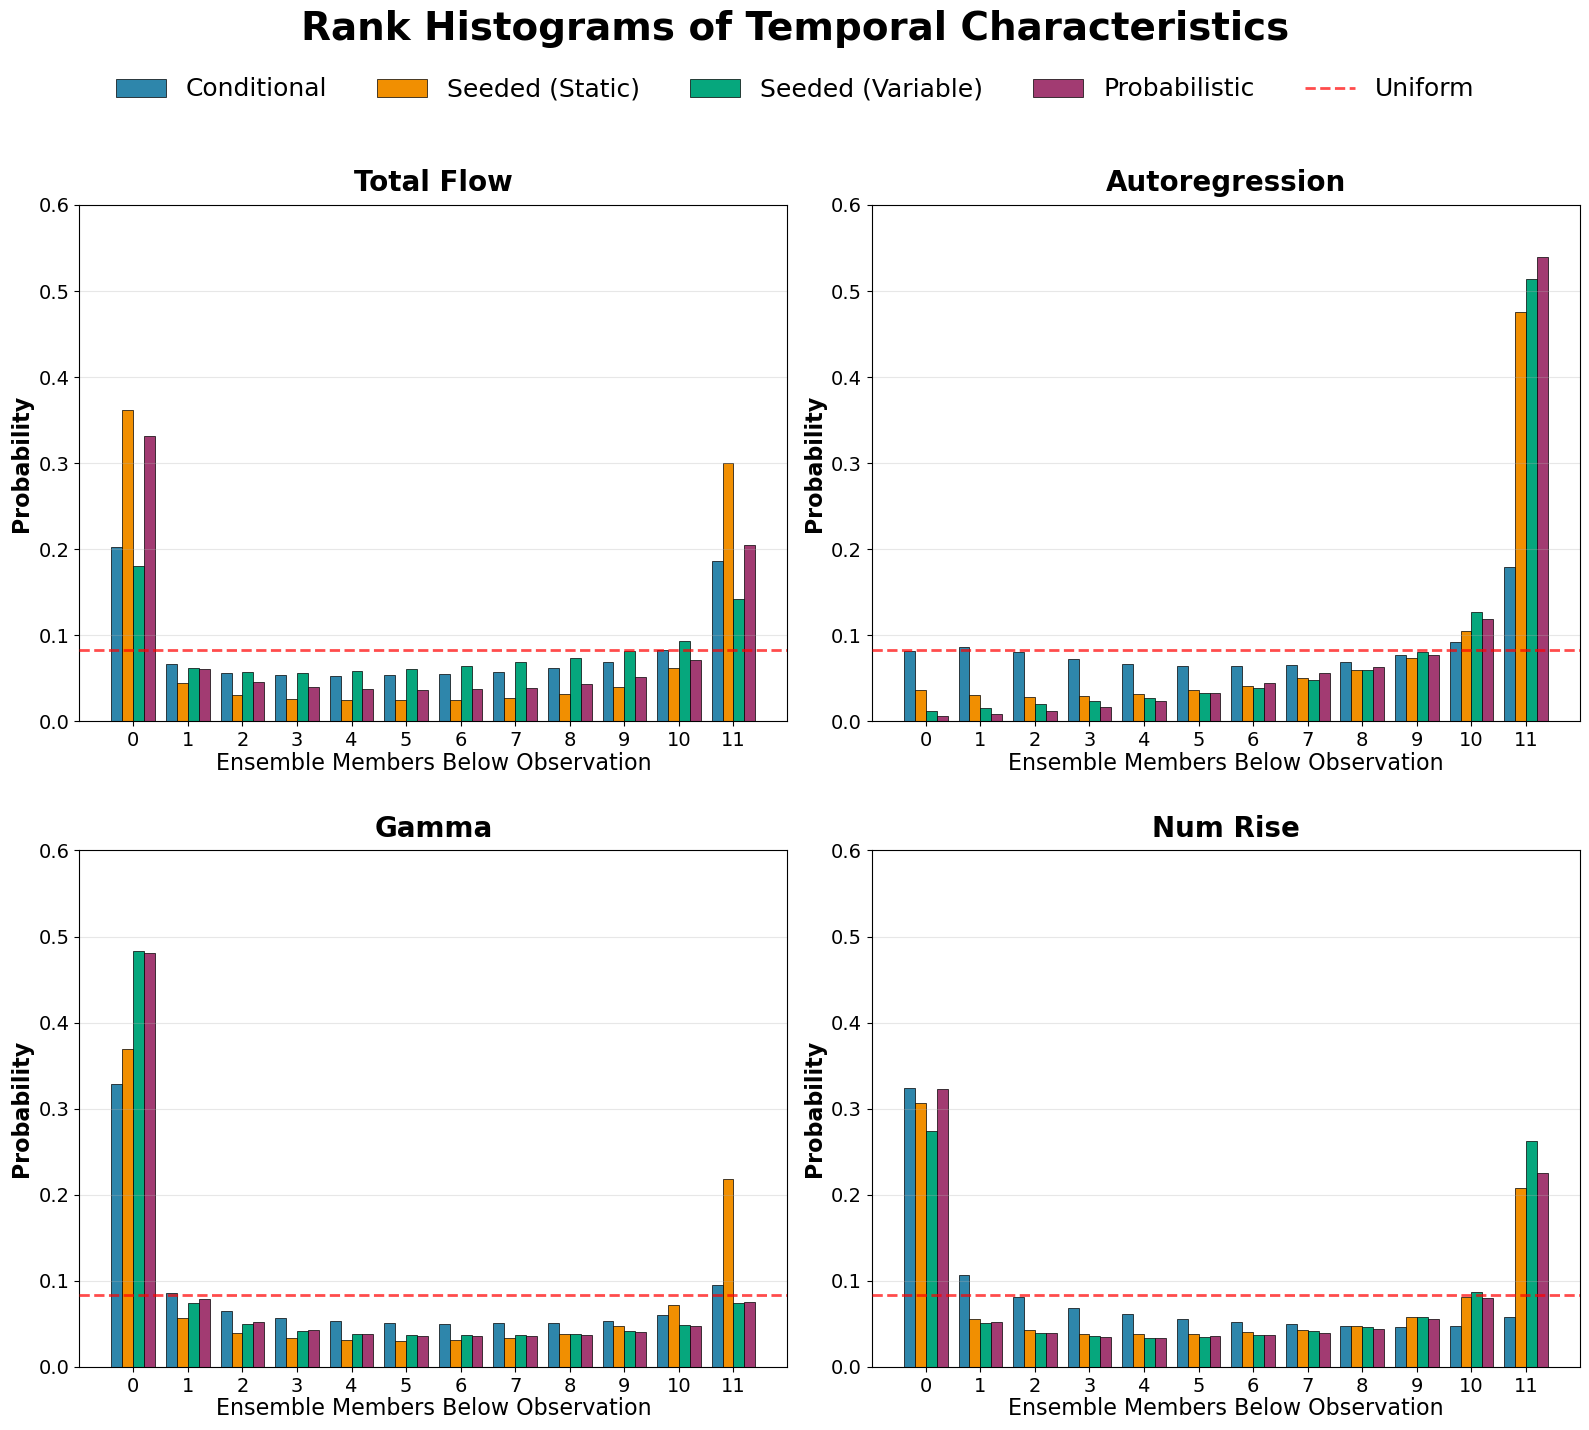

In [21]:
fig = plt.figure(figsize=(16, 15))
fig.suptitle('Rank Histograms of Temporal Characteristics', fontsize=28, fontweight='bold', y=0.95)

# Create subplots
axes = fig.subplots(2, 2)
axes = axes.flatten()

# Lists to store handles and labels for the global legend
global_handles = []
global_labels = []

for i, metric in enumerate(metrics):
    ax = axes[i]
    
    # Extract data for current metric
    metric_columns = [col for col in dispersion_df.columns if metric in col]
    
    model_names = []
    metric_values = []
    
    for col in metric_columns:
        # Extract model name
        model_name = col.replace(f'_{metric}', '')
        
        display_name = model_name_mapping.get(model_name, model_name) if 'model_name_mapping' in locals() else model_name
            
        model_names.append(display_name)
        metric_values.append(dispersion_df[col].values / 100) 
    
    # Rank bins
    rank_bins = dispersion_df.index.tolist()
    
    # Bar plot setup
    num_models = len(model_names)
    x = np.arange(len(rank_bins)) 
    width = 0.8 / num_models 
    
    for j, values in enumerate(metric_values):
        # --- FIX 2: Capture the bar object for the legend ---
        bar = ax.bar(
            x + j * width, 
            values, 
            width=width, 
            label=model_names[j], # Label is assigned here
            color=colors[j % len(colors)],
            edgecolor='black',
            linewidth=0.5
        )
        
        # Store handles/labels ONLY from the first subplot to avoid duplicates
        if i == 0:
            global_handles.append(bar)
            global_labels.append(model_names[j])
    
    # --- FIX 3: Add Red Line to Legend as 'Uniform' ---
    ideal_probability = 1.0 / len(rank_bins)
    uniform_line = ax.axhline(y=ideal_probability, color='red', linestyle='--', linewidth=2, 
               alpha=0.7, zorder=10, label='Uniform')
    
    # Add the Uniform line to the global legend lists (only once)
    if i == 0:
        global_handles.append(uniform_line)
        global_labels.append('Uniform')

    # Improved formatting
    metric_title = metric.replace('_', ' ').title()
    ax.set_title(f"{metric_title}", fontsize=20, fontweight='bold', pad=10)
    ax.set_xlabel("Ensemble Members Below Observation", fontsize=16, labelpad=1)
    ax.set_ylabel("Probability", fontsize=16, fontweight='bold')
    ax.set_xticks(x + width * (num_models - 1) / 2)
    ax.set_xticklabels(rank_bins, fontsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Disable individual subplot legends
    if ax.get_legend():
        ax.legend().set_visible(False)

for ax in axes:
    ax.set_ylim(0, 0.6)

# Create single legend at the top using the collected HANDLES
# Note: ncol includes len(models) + 1 for the Uniform line
fig.legend(handles=global_handles, labels=global_labels, 
           loc='upper center', bbox_to_anchor=(0.5, 0.92), 
           ncol=len(global_labels), fontsize=18, frameon=False, 
           fancybox=False, shadow=True)

plt.tight_layout()
plt.subplots_adjust(top=0.82, hspace=0.25)
plt.show()

In [22]:
metadata['basin_idx']

array(['hysets_07311900', 'hysets_07311900', 'hysets_07311900', ...,
       'hysets_09442000', 'hysets_09442000', 'hysets_09442000'],
      dtype=object)

# Making CRPS Map

In [24]:
from collections import defaultdict

def create_basin_crps_tables(crps_per_leadtime, basins):
    """
    Create tables showing average CRPS at each leadtime for each basin.
    
    Parameters:
    - crps_per_leadtime: dict with keys ['Conditional', 'Seeded (Static)', 'Seeded (Variable)', 'Probabilistic']
    - basins: list of basin identifiers corresponding to each forecast
    
    Returns:
    - Dictionary of DataFrames, one for each model type
    """
    
    # Get the model types (excluding non-CRPS metrics if present)
    model_types = [key for key in crps_per_leadtime.keys() if key != "NLL"] 
    # Dictionary to store results for each model
    basin_tables = {}
    
    for model_type in model_types:
        print(f"\nProcessing {model_type}...")
        
        # Get CRPS data for this model
        crps_data = crps_per_leadtime[model_type]
        
        # Convert to numpy array if it's a list of tensors
        if isinstance(crps_data[0], torch.Tensor):
            crps_array = torch.stack(crps_data).cpu().numpy().squeeze()
        else:
            crps_array = np.array(crps_data).squeeze()

        # crps_array should be shape (n_forecasts, n_leadtimes)
        n_forecasts, n_leadtimes = crps_array.shape
        
        # Create a dictionary to group by basin
        basin_crps = defaultdict(list)
        
        # Group CRPS scores by basin
        basins_array = np.array(basins)
        unique_basins = np.unique(basins_array)

        
        # Method 1: Using broadcasting and boolean masking (fastest for most cases)
        basin_avg_crps = {}
        for basin in unique_basins:
            mask = basins_array == basin 
            mask = mask.squeeze()  # (shape, n_forecasts,)
            basin_forecasts = crps_array[mask]  # Get all forecasts for this basin
            basin_avg_crps[basin] = np.mean(basin_forecasts, axis=0) 

        
        
        # Create DataFrame
        leadtime_columns = [f'Leadtime_{i+1}' for i in range(n_leadtimes)]
        
        # Convert to DataFrame
        df_data = []
        for basin, avg_crps in basin_avg_crps.items():
            row = [basin] + list(avg_crps)
            df_data.append(row)
        
        df = pd.DataFrame(df_data, columns=['Basin'] + leadtime_columns)
        df = df.sort_values('Basin').reset_index(drop=True)
        
        
        basin_tables[model_type] = df
        
        print(f"{model_type} table created:")
        print(f"- {len(basin_avg_crps)} unique basins")
        print(f"- {n_leadtimes} leadtimes")
        print(f"- Total forecasts: {n_forecasts}")
    
    return basin_tables

def print_basin_tables(basin_tables, max_rows=None):
    """
    Print the basin tables in a nice format.
    
    Parameters:
    - basin_tables: Dictionary of DataFrames from create_basin_crps_tables
    - max_rows: Maximum number of rows to display (None for all)
    """
    
    for model_type, df in basin_tables.items():
        print(f"\n{'='*60}")
        print(f"AVERAGE CRPS BY LEADTIME - {model_type.upper()}")
        print(f"{'='*60}")
        
        if max_rows is not None and len(df) > max_rows:
            print(df.head(max_rows))
            print(f"... ({len(df) - max_rows} more rows)")
        else:
            print(df)
        
        avg_crps_by_basin = df[df.columns[1:]].mean(axis=1)
        
        min_idx = avg_crps_by_basin.idxmin()
        max_idx = avg_crps_by_basin.idxmax()
        
        print(f"\nBasin with lowest average CRPS: {df.loc[min_idx, 'Basin']} (CRPS: {avg_crps_by_basin[min_idx]:.4f})")
        print(f"Basin with highest average CRPS: {df.loc[max_idx, 'Basin']} (CRPS: {avg_crps_by_basin[max_idx]:.4f})")


In [25]:
# 1. Add the basins array as a column
basins = metadata['basin_idx']
flow_crps_df['Basin'] = basins
autoregression_crps_df['Basin'] = basins
gamma_crps_df['Basin'] = basins
num_rise_crps_df['Basin'] = basins

# 2. Group by Basin and calculate the mean over the arrays in each cell
# np.stack turns the list of arrays into a matrix, axis=0 averages across the rows (forecasts)
# 1. Group by Basin and average the arrays (as established before)
flow_crps_df['Basin'] = basins
grouped = flow_crps_df.groupby('Basin', as_index=False).agg(lambda x: np.mean(np.stack(x), axis=0))

# 2. Melt (Model to column) and Explode (expand lists into rows)
long_flow_df = grouped.melt(id_vars='Basin', var_name='Model', value_name='CRPS').explode('CRPS')

# 3. Add a Leadtime column (automatically counts 1, 2, 3... for each group)
long_flow_df['Leadtime'] = long_flow_df.groupby(['Basin', 'Model']).cumcount() + 1

# Ensure the CRPS column is numeric (explode sometimes leaves it as object)
long_flow_df['CRPS'] = long_flow_df['CRPS'].astype(float)

print(long_flow_df.head())

               Basin        Model    CRPS  Leadtime
0  camelsbr_35740000  Conditional  2.9867         1
1  camelsbr_36580000  Conditional  0.2066         1
2  camelsbr_39560000  Conditional  1.1806         1
3  camelsbr_44200000  Conditional  0.6821         1
4  camelsbr_44290002  Conditional  0.6609         1


In [26]:
def process_crps_df(crps_df, basins, metric_name):
    crps_df['Basin'] = basins    
    grouped = crps_df.groupby('Basin', as_index=False).agg(lambda x: np.mean(np.stack(x), axis=0))
    long_df = grouped.melt(id_vars='Basin', var_name='Model', value_name='CRPS').explode('CRPS')
    long_df['Leadtime'] = long_df.groupby(['Basin', 'Model']).cumcount() + 1
    long_df['CRPS'] = long_df['CRPS'].astype(float)
        
    return long_df


long_flow_df = process_crps_df(flow_crps_df, basins, 'total_flow')
long_autoregression_df = process_crps_df(autoregression_crps_df, basins, 'autoregression')
long_gamma_df = process_crps_df(gamma_crps_df, basins, 'gamma')
long_num_rise_df = process_crps_df(num_rise_crps_df, basins, 'num_rise')
    

In [27]:
Conditional_Flow_DF = long_flow_df[long_flow_df['Model'] == 'Conditional']

In [28]:
basin_tables = create_basin_crps_tables(crps_per_leadtime, basins)



Processing Conditional...
Conditional table created:
- 699 unique basins
- 10 leadtimes
- Total forecasts: 695505

Processing Seeded (Static)...
Seeded (Static) table created:
- 699 unique basins
- 10 leadtimes
- Total forecasts: 695505

Processing Seeded (Variable)...
Seeded (Variable) table created:
- 699 unique basins
- 10 leadtimes
- Total forecasts: 695505

Processing Probabilistic...
Probabilistic table created:
- 699 unique basins
- 10 leadtimes
- Total forecasts: 695505


In [29]:
basin_tables['Conditional']

,Basin,Leadtime_1,Leadtime_2,Leadtime_3,Leadtime_4,Leadtime_5,Leadtime_6,Leadtime_7,Leadtime_8,Leadtime_9,Leadtime_10
0,camelsbr_35740000,0.2561,0.2663,0.2707,0.2784,0.2856,0.2915,0.2956,0.3005,0.3036,0.3060
1,camelsbr_36580000,0.0086,0.0086,0.0067,0.0061,0.0057,0.0059,0.0059,0.0060,0.0062,0.0071
2,camelsbr_39560000,0.0833,0.0806,0.0782,0.0834,0.0882,0.0966,0.0978,0.0997,0.1039,0.1089
3,camelsbr_44200000,0.0633,0.0539,0.0487,0.0465,0.0479,0.0497,0.0523,0.0550,0.0589,0.0624
4,camelsbr_44290002,0.0640,0.0521,0.0455,0.0440,0.0446,0.0460,0.0496,0.0529,0.0561,0.0586
...,...,...,...,...,...,...,...,...,...,...,...
694,hysets_14303600,0.9113,0.8426,0.7634,0.7806,0.8941,1.0214,1.1024,1.1305,1.2138,1.3273
695,hysets_14305500,1.3209,1.1306,1.1282,1.1738,1.2290,1.3747,1.4492,1.4856,1.6432,1.7169
696,hysets_14309500,0.6647,0.6693,0.6701,0.6536,0.6465,0.7063,0.7186,0.6943,0.7280,0.7829
697,hysets_14338000,0.2322,0.1865,0.1745,0.2306,0.2209,0.2412,0.2326,0.2369,0.2854,0.3135


In [48]:
def add_coordinates_to_basin_table(basin_tables_df, csv_base_path="/perm/mokr/Caravans/Caravan/attributes/"):
    """
    Add latitude and longitude columns to the basin tables DataFrame by reading location CSV files.
    
    Parameters:
    - basin_tables_df: DataFrame with Basin column in format {location}_{gauge_id}
    - csv_base_path: Base path to the CSV files
    
    Returns:
    - DataFrame with added 'Latitude' and 'Longitude' columns
    """
    
    # Extract unique locations from basin names
    print("Extracting unique locations from basin names...")
    locations = set()
    basin_to_location = {}
    
    for basin in basin_tables_df['Basin']:

        # Split by underscore and take the first part as location
        location = basin.split('_')[0]
        locations.add(location)
        basin_to_location[basin] = location
    
    print(f"Found {len(locations)} unique locations: {sorted(locations)}")
    
    # Dictionary to store coordinates for each location
    location_coordinates = {}
    
    # Read CSV files for each location
    for location in locations:
        csv_filename = f"{location}/attributes_other_{location}.csv"
        csv_path = os.path.join(csv_base_path, csv_filename)
        

        df_coords = pd.read_csv(csv_path)
        location_coordinates[location] = df_coords

    # Add coordinate columns to the basin tables
    print("\nAdding coordinates to basin table...")
    
    # Initialize new columns
    basin_tables_df['Latitude'] = np.nan
    basin_tables_df['Longitude'] = np.nan
    basin_tables_df['Location'] = None
    
    # Iterate through each row and add coordinates
    for idx, row in basin_tables_df.iterrows():
        basin = row['Basin']
        location = basin_to_location.get(basin)
        
        if location is None:
            continue
            
        basin_tables_df.at[idx, 'Location'] = location

        gauge_id = basin  # Everything after first underscore
        
        # Look up coordinates for this gauge_id in the location's CSV
        coord_df = location_coordinates.get(location)
        if coord_df is None:
            continue
        
        gauge_col = 'gauge_id'
                
        # Find matching row in coordinates CSV
        matching_rows = coord_df[coord_df[gauge_col].astype(str) == str(gauge_id)]

        
        # Extract coordinates
        coord_row = matching_rows.iloc[0]
        
        # Try different possible column names for latitude/longitude
        lat_col = 'gauge_lat'
        lon_col = 'gauge_lon'
        
        lat_val = coord_row[lat_col]
        lon_val = coord_row[lon_col]

        basin_tables_df.at[idx, 'Latitude'] = float(lat_val)
        basin_tables_df.at[idx, 'Longitude'] = float(lon_val)
    
    # Summary statistics
    total_basins = len(basin_tables_df)
    basins_with_coords = basin_tables_df[['Latitude', 'Longitude']].notna().all(axis=1).sum()
    
    print(f"\n{'='*50}")
    print(f"COORDINATE MATCHING SUMMARY")
    print(f"{'='*50}")
    print(f"Total basins: {total_basins}")
    print(f"Basins with coordinates: {basins_with_coords}")
    print(f"Success rate: {basins_with_coords/total_basins*100:.1f}%")
    
    # Reorder columns to put coordinates near Basin
    cols = basin_tables_df.columns.tolist()
    # Move Location, Latitude, Longitude to after Basin
    basin_idx = cols.index('Basin')
    new_cols = cols[:basin_idx+1] + ['Latitude', 'Longitude'] + [c for c in cols if c not in ['Basin', 'Latitude', 'Longitude']]
    basin_tables_df = basin_tables_df[new_cols]
    
    return basin_tables_df

In [49]:
CRPS_df = add_coordinates_to_basin_table(basin_tables['Conditional'], csv_base_path="/perm/mokr/Caravans/Caravan/attributes/")
Probabilistic_df = add_coordinates_to_basin_table(basin_tables['Probabilistic'], csv_base_path="/perm/mokr/Caravans/Caravan/attributes/")

Flow_df = add_coordinates_to_basin_table(long_flow_df, csv_base_path="/perm/mokr/Caravans/Caravan/attributes/")
Autoregression_df = add_coordinates_to_basin_table(long_autoregression_df, csv_base_path="/perm/mokr/Caravans/Caravan/attributes/")
Gamma_df = add_coordinates_to_basin_table(long_gamma_df, csv_base_path="/perm/mokr/Caravans/Caravan/attributes/")
NumRise_df = add_coordinates_to_basin_table(long_num_rise_df, csv_base_path="/perm/mokr/Caravans/Caravan/attributes/")

Extracting unique locations from basin names...
Found 3 unique locations: ['camelsbr', 'camelscl', 'hysets']

Adding coordinates to basin table...

COORDINATE MATCHING SUMMARY
Total basins: 699
Basins with coordinates: 699
Success rate: 100.0%
Extracting unique locations from basin names...
Found 3 unique locations: ['camelsbr', 'camelscl', 'hysets']

Adding coordinates to basin table...

COORDINATE MATCHING SUMMARY
Total basins: 699
Basins with coordinates: 699
Success rate: 100.0%
Extracting unique locations from basin names...
Found 3 unique locations: ['camelsbr', 'camelscl', 'hysets']

Adding coordinates to basin table...

COORDINATE MATCHING SUMMARY
Total basins: 2796
Basins with coordinates: 2796
Success rate: 100.0%
Extracting unique locations from basin names...
Found 3 unique locations: ['camelsbr', 'camelscl', 'hysets']

Adding coordinates to basin table...

COORDINATE MATCHING SUMMARY
Total basins: 2796
Basins with coordinates: 2796
Success rate: 100.0%
Extracting unique lo

,Basin,Latitude,Longitude,Leadtime_1,Leadtime_2,Leadtime_3,Leadtime_4,Leadtime_5,Leadtime_6,Leadtime_7,Leadtime_8,Leadtime_9,Leadtime_10,Location
0,camelsbr_35740000,-4.1933,-38.7797,0.2561,0.2663,0.2707,0.2784,0.2856,0.2915,0.2956,0.3005,0.3036,0.3060,camelsbr
1,camelsbr_36580000,-5.1219,-38.4464,0.0086,0.0086,0.0067,0.0061,0.0057,0.0059,0.0059,0.0060,0.0062,0.0071,camelsbr
2,camelsbr_39560000,-8.6794,-35.5769,0.0833,0.0806,0.0782,0.0834,0.0882,0.0966,0.0978,0.0997,0.1039,0.1089,camelsbr
3,camelsbr_44200000,-15.9494,-44.8678,0.0633,0.0539,0.0487,0.0465,0.0479,0.0497,0.0523,0.0550,0.0589,0.0624,camelsbr
4,camelsbr_44290002,-15.6011,-44.3967,0.0640,0.0521,0.0455,0.0440,0.0446,0.0460,0.0496,0.0529,0.0561,0.0586,camelsbr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694,hysets_14303600,45.2665,-123.8471,0.9113,0.8426,0.7634,0.7806,0.8941,1.0214,1.1024,1.1305,1.2138,1.3273,hysets
695,hysets_14305500,44.7151,-123.8873,1.3209,1.1306,1.1282,1.1738,1.2290,1.3747,1.4492,1.4856,1.6432,1.7169,hysets
696,hysets_14309500,42.8040,-123.6109,0.6647,0.6693,0.6701,0.6536,0.6465,0.7063,0.7186,0.6943,0.7280,0.7829,hysets
697,hysets_14338000,42.6787,-122.7420,0.2322,0.1865,0.1745,0.2306,0.2209,0.2412,0.2326,0.2369,0.2854,0.3135,hysets


In [50]:
def create_model_dict(df):
    """Create a dictionary splitting dataframe by Model."""
    return {model: df[df['Model'] == model] for model in df['Model'].unique()}

# Create all dictionaries
Flow_dict = create_model_dict(Flow_df)
Autoregression_dict = create_model_dict(Autoregression_df)
Gamma_dict = create_model_dict(Gamma_df)
NumRise_dict = create_model_dict(NumRise_df)

In [51]:
def add_coordinates_to_df_pivot(df_pivot, csv_base_path="/perm/mokr/Caravans/Caravan/attributes/"):
    """
    Add latitude and longitude columns to the df_pivot DataFrame by reading location CSV files.
    
    Parameters:
    - df_pivot: DataFrame with 'model' and 'catchment' columns, where catchment is in format {location}_{gauge_id}
    - csv_base_path: Base path to the CSV files
    
    Returns:
    - DataFrame with added 'Latitude' and 'Longitude' columns
    """
    
    # Extract unique locations from catchment names
    locations = set()
    catchment_to_location = {}
    
    for catchment in df_pivot['catchment'].unique():
        location = catchment.split('_')[0]
        locations.add(location)
        catchment_to_location[catchment] = location
        
    # Dictionary to store coordinates for each location
    location_coordinates = {}
    
    # Read CSV files for each location
    for location in locations:
        csv_filename = f"{location}/attributes_other_{location}.csv"
        csv_path = os.path.join(csv_base_path, csv_filename)        
        try:
            df_coords = pd.read_csv(csv_path)
            location_coordinates[location] = df_coords
        except FileNotFoundError:
            print(f"  WARNING: Could not find CSV for {location}")
    
    catchment_coords = {}    
    for catchment in df_pivot['catchment'].unique():
        location = catchment_to_location.get(catchment)
        
        if location is None:
            continue
            
        gauge_id = catchment  # Full catchment name
        
        # Look up coordinates for this gauge_id in the location's CSV
        coord_df = location_coordinates.get(location)
        if coord_df is None:
            continue
        
        gauge_col = 'gauge_id'
        
        # Find matching row in coordinates CSV
        matching_rows = coord_df[coord_df[gauge_col].astype(str) == str(gauge_id)]
        
        if len(matching_rows) == 0:
            continue
            
        # Extract coordinates
        coord_row = matching_rows.iloc[0]
        
        lat_col = 'gauge_lat'
        lon_col = 'gauge_lon'
        lat_val = float(coord_row[lat_col])
        lon_val = float(coord_row[lon_col])
        catchment_coords[catchment] = {'Latitude': lat_val, 'Longitude': lon_val, 'Location': location}
    
    # Add coordinates to df_pivot using the mapping
    print("\nAdding coordinates to df_pivot...")
    df_pivot['Latitude'] = df_pivot['catchment'].map(lambda c: catchment_coords.get(c, {}).get('Latitude', np.nan))
    df_pivot['Longitude'] = df_pivot['catchment'].map(lambda c: catchment_coords.get(c, {}).get('Longitude', np.nan))
    df_pivot['Location'] = df_pivot['catchment'].map(lambda c: catchment_coords.get(c, {}).get('Location', None))
    
    # Summary statistics
    total_catchments = df_pivot['catchment'].nunique()
    catchments_with_coords = len([c for c in catchment_coords if not np.isnan(catchment_coords[c]['Latitude'])])
    
    # Reorder columns to put coordinates near catchment
    cols = df_pivot.columns.tolist()
    # Move Location, Latitude, Longitude to after catchment
    catchment_idx = cols.index('catchment')
    leadtime_cols = [c for c in cols if c.startswith('leadtime_')]
    other_cols = [c for c in cols if c not in ['model', 'catchment', 'Latitude', 'Longitude', 'Location'] and c not in leadtime_cols]
    new_cols = ['model', 'catchment', 'Latitude', 'Longitude', 'Location'] + other_cols + leadtime_cols
    df_pivot = df_pivot[new_cols]
    
    return df_pivot

# Usage
df_pivot = add_coordinates_to_df_pivot(df_pivot)



Adding coordinates to df_pivot...


In [52]:
# CRPS_df = df_pivot[df_pivot['model'] == 'Conditional'].reset_index(drop=True)
# Probabilistic_df = df_pivot[df_pivot['model'] == 'Probabilistic'].reset_index(drop=True)

In [53]:
import geopandas as gpd
from matplotlib.colors import LogNorm

shapefile_path="/home/mokr/GLOFAS_ML_Flood_Modelling/data/ne_110m_admin_0_countries/raw/ne_110m_admin_0_countries.shp"
world = gpd.read_file(shapefile_path)



In [54]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np


In [55]:
# Merge on coordinates
leadtime = 10
merged = CRPS_df[['Latitude','Longitude',f'Leadtime_{leadtime}']].merge(
    Probabilistic_df[['Latitude','Longitude',f'Leadtime_{leadtime}']],
    on=['Latitude','Longitude'],
    suffixes=("_CRPS", "_Prob")
)

# Difference: CRPS - NonBinary
merged['difference'] = 1 - (merged[f'Leadtime_{leadtime}_CRPS']/merged[f'Leadtime_{leadtime}_Prob']) 
merged['abs_difference'] = merged[f'Leadtime_{leadtime}_CRPS'] - merged[f'Leadtime_{leadtime}_Prob']

# Convert to GeoDataFrame
gdf_diff = gpd.GeoDataFrame(
    merged,
    geometry=gpd.points_from_xy(merged.Longitude, merged.Latitude),
    crs="EPSG:4326"
)

In [56]:
Flow_dict['Conditional']
Flow_dict['Probabilistic']


,Basin,Latitude,Longitude,Model,CRPS,Leadtime,Location
2097,camelsbr_35740000,-4.1933,-38.7797,Probabilistic,3.9266,1,camelsbr
2098,camelsbr_36580000,-5.1219,-38.4464,Probabilistic,0.2222,1,camelsbr
2099,camelsbr_39560000,-8.6794,-35.5769,Probabilistic,1.0649,1,camelsbr
2100,camelsbr_44200000,-15.9494,-44.8678,Probabilistic,0.8066,1,camelsbr
2101,camelsbr_44290002,-15.6011,-44.3967,Probabilistic,0.7725,1,camelsbr
...,...,...,...,...,...,...,...
2791,hysets_14303600,45.2665,-123.8471,Probabilistic,12.1845,1,hysets
2792,hysets_14305500,44.7151,-123.8873,Probabilistic,14.3906,1,hysets
2793,hysets_14309500,42.8040,-123.6109,Probabilistic,7.7353,1,hysets
2794,hysets_14338000,42.6787,-122.7420,Probabilistic,2.9460,1,hysets


In [57]:
merged['difference'].min()

np.float32(-3.4625883)

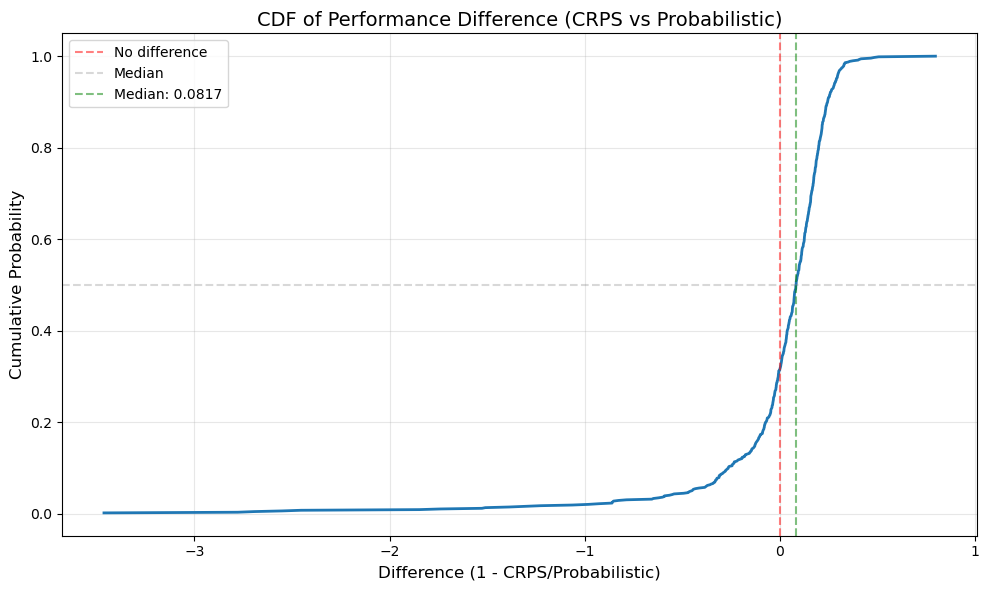

Summary Statistics for Difference:
Mean: 0.0113
Median: 0.0817
Std Dev: 0.3550
Min: -3.4626
Max: 0.7958
% of locations where CRPS < Probabilistic: 68.38%


In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Sort the differences
sorted_diff = np.sort(merged['difference'])

# Calculate the cumulative probabilities
cumulative_prob = np.arange(1, len(sorted_diff) + 1) / len(sorted_diff)

# Create the CDF plot
plt.figure(figsize=(10, 6))
plt.plot(sorted_diff, cumulative_prob, linewidth=2)
plt.xlabel('Difference (1 - CRPS/Probabilistic)', fontsize=12)
plt.ylabel('Cumulative Probability', fontsize=12)
plt.title('CDF of Performance Difference (CRPS vs Probabilistic)', fontsize=14)
plt.grid(True, alpha=0.3)

# Add reference lines
plt.axvline(x=0, color='red', linestyle='--', alpha=0.5, label='No difference')
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.3, label='Median')

# Add median value annotation
median_diff = np.median(merged['difference'])
plt.axvline(x=median_diff, color='green', linestyle='--', alpha=0.5, label=f'Median: {median_diff:.4f}')

plt.legend()
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Summary Statistics for Difference:")
print(f"Mean: {merged['difference'].mean():.4f}")
print(f"Median: {median_diff:.4f}")
print(f"Std Dev: {merged['difference'].std():.4f}")
print(f"Min: {merged['difference'].min():.4f}")
print(f"Max: {merged['difference'].max():.4f}")
print(f"% of locations where CRPS < Probabilistic: {(merged['difference'] > 0).mean()*100:.2f}%")

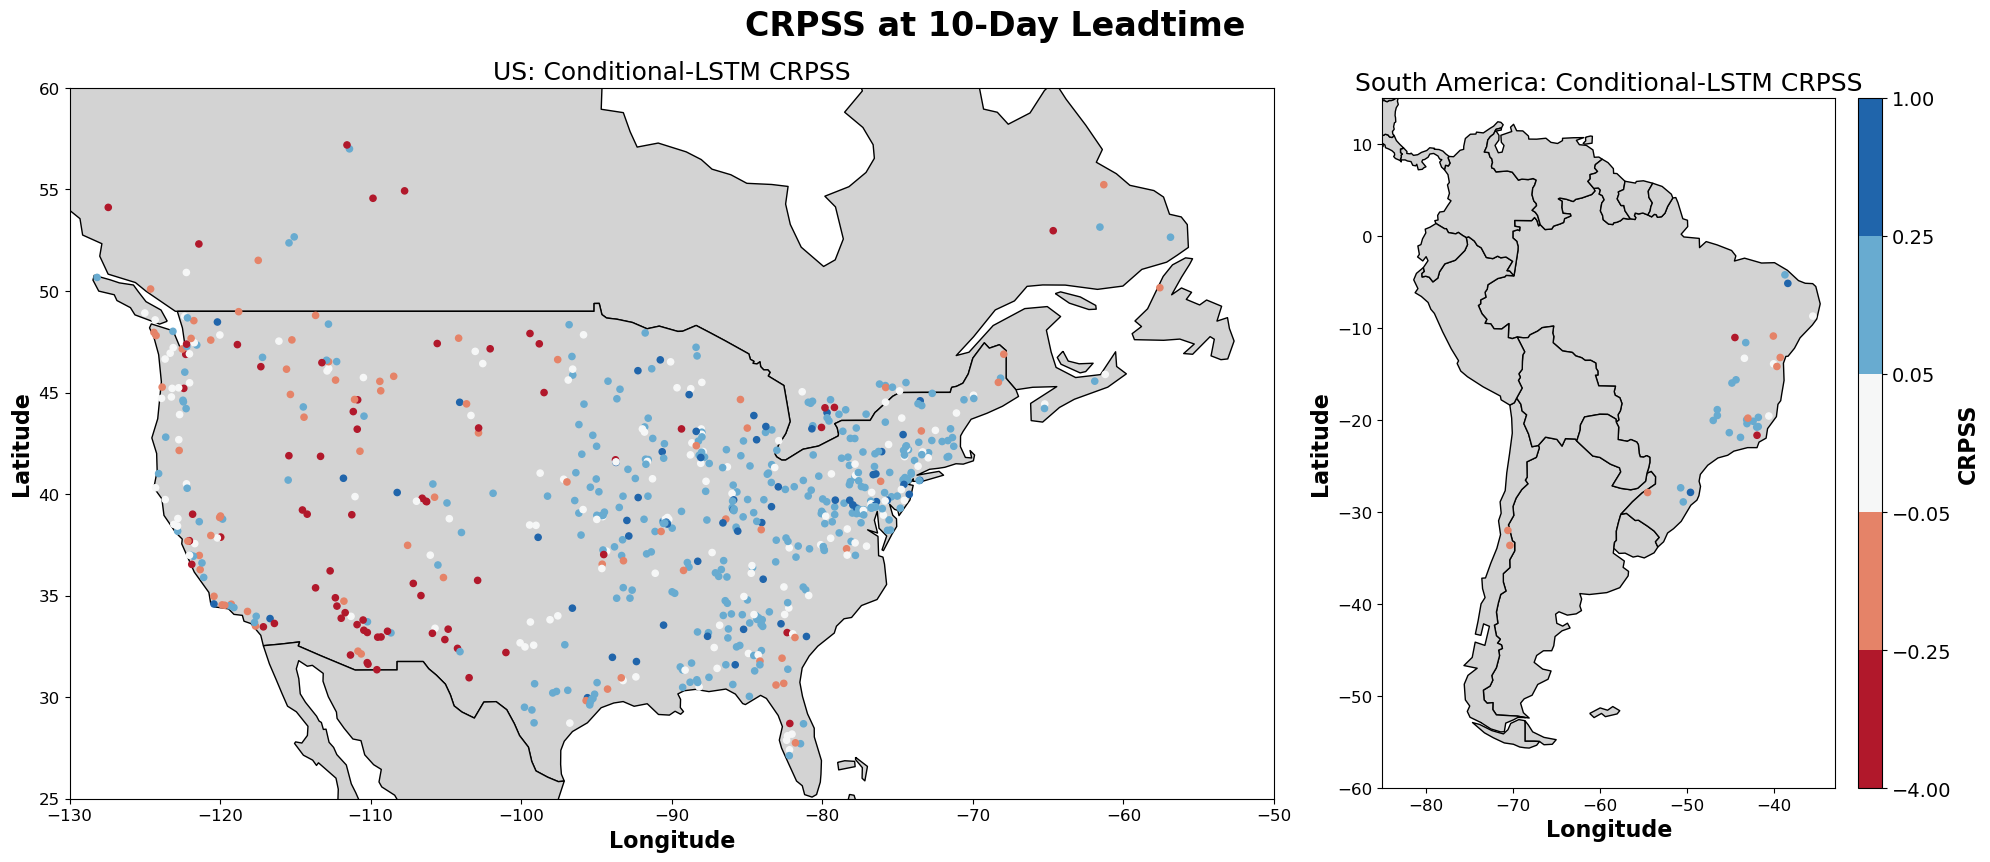

In [59]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

# --- Choose discrete difference bounds (adjust as needed) ---
bounds = [-4, -0.25, -0.05, 0.05, 0.25, 1]
base_cmap = plt.get_cmap('RdBu')   # diverging colormap
n_colours = len(bounds) - 1  # Number of color segments
colors = base_cmap([0.1, 0.25, 0.5, 0.75, 0.9])
cmap = mcolors.ListedColormap(colors)
# norm = mcolors.TwoSlopeNorm(0, -1, 1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# --- 2 Subplots ---
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2.35, 1]}, figsize=(20, 10))
fig.suptitle('CRPSS at 10-Day Leadtime', fontsize=24, fontweight='bold', y=0.91)

Title_Size = 18

# ========== US MAP ==========
world.plot(ax=ax1, color='lightgray', edgecolor='black')

us_gdf = gdf_diff[(gdf_diff.geometry.x >= -130) & (gdf_diff.geometry.x <= -50) &
                  (gdf_diff.geometry.y >= 25) & (gdf_diff.geometry.y <= 60)]

us_gdf.plot(
    column='difference',
    ax=ax1,
    cmap=cmap,
    norm=norm,
    legend=False,
    markersize=20
)

ax1.set_title('US: Conditional-LSTM CRPSS', fontsize=Title_Size)
ax1.set_xlim([-130, -50])
ax1.set_ylim([25, 60])

# ========== BRAZIL MAP ==========
world.plot(ax=ax2, color='lightgray', edgecolor='black')

brazil_gdf = gdf_diff[(gdf_diff.geometry.x >= -75) & (gdf_diff.geometry.x <= -35) &
                      (gdf_diff.geometry.y >= -35) & (gdf_diff.geometry.y <= 10)]

brazil_gdf.plot(
    column='difference',
    ax=ax2,
    cmap=cmap,
    norm=norm,
    legend=False,
    markersize=20
)

ax2.set_title('South America: Conditional-LSTM CRPSS', fontsize=Title_Size)
ax2.set_xlim([-85, -33])
ax2.set_ylim([-60, 15])

for ax in [ax1, ax2]:
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlabel('Longitude', fontsize=16, fontweight='bold')
    ax.set_ylabel('Latitude', fontsize=16, fontweight='bold')

# --- Single Colorbar ---
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.1)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax)
cbar.ax.tick_params(labelsize=14)
cbar.set_label("CRPSS", fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()



In [42]:
np.linspace(0.1, 0.9, n_colours)

array([0.1, 0.3, 0.5, 0.7, 0.9])

In [43]:

def calculate_crpss(conditional_dict, probabilistic_dict, metric_dicts):
    """
    Calculate CRPSS (Continuous Ranked Probability Skill Score) for multiple metrics.
    
    Parameters:
    -----------
    conditional_dict : str
        Name of the conditional model in the dictionaries
    probabilistic_dict : str
        Name of the probabilistic (baseline) model in the dictionaries
    metric_dicts : dict
        Dictionary mapping metric names to their corresponding model dictionaries
        e.g., {'Total_Flow': Flow_dict, 'Autocorrelation': Autoregression_dict}
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with CRPSS for each metric
    """
    CRPSS_Stats = pd.DataFrame()
    
    for metric_name, model_dict in metric_dicts.items():
        CRPSS_Stats[metric_name] = 1 - (
            model_dict[conditional_dict]['CRPS'].reset_index(drop=True) / 
            model_dict[probabilistic_dict]['CRPS'].reset_index(drop=True)
        )
    
    return CRPSS_Stats

# Usage:
metric_dicts = {
    'Total_Flow': Flow_dict,
    'Autocorrelation': Autoregression_dict,
    'Gamma': Gamma_dict,
    'NumRise': NumRise_dict
}

CRPSS_Stats = calculate_crpss('Conditional', 'Probabilistic', metric_dicts)

CRPSS_Stats['Latitude'] = Flow_dict['Conditional']['Latitude'].reset_index(drop=True)
CRPSS_Stats['Longitude'] = Flow_dict['Conditional']['Longitude'].reset_index(drop=True)
# Convert to GeoDataFrame
gdf_diff = gpd.GeoDataFrame(
    CRPSS_Stats,
    geometry=gpd.points_from_xy(CRPSS_Stats.Longitude, CRPSS_Stats.Latitude),
    crs="EPSG:4326"
)

In [44]:
CRPSS_Stats['Gamma'].max()

np.float64(0.6440228826296917)

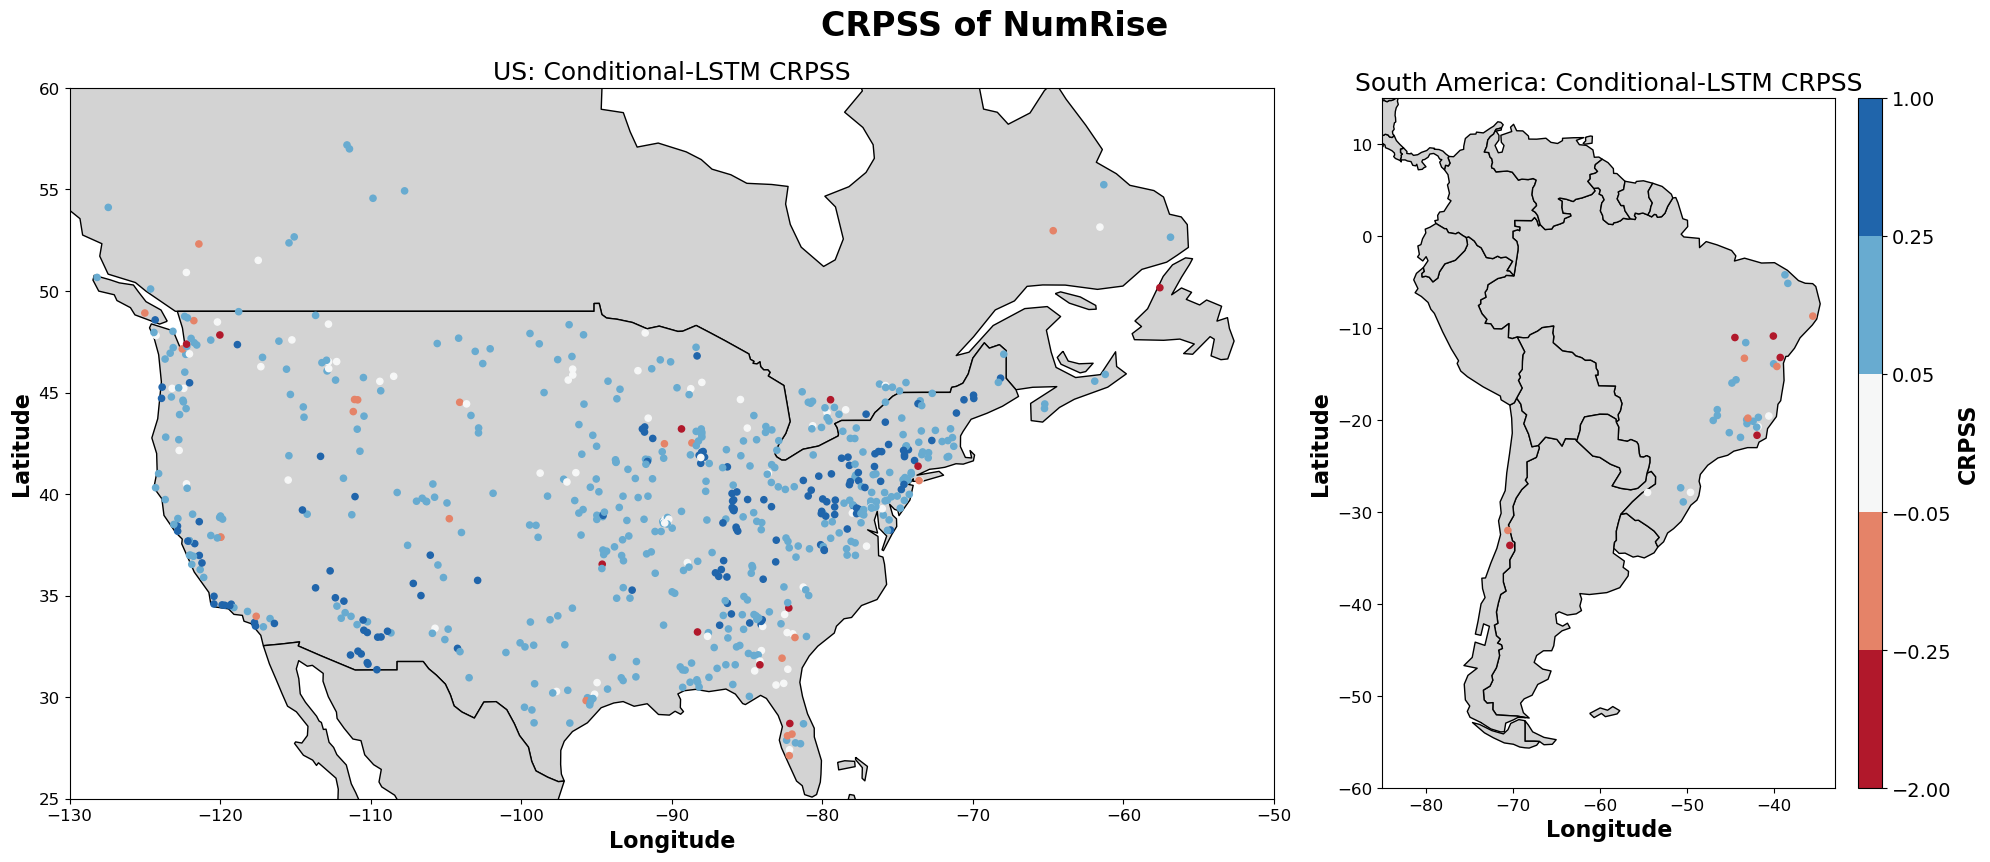

In [46]:
# --- Choose discrete difference bounds (adjust as needed) ---
bounds = [-2, -0.25, -0.05, 0.05, 0.25, 1]
base_cmap = plt.get_cmap('RdBu')   # diverging colormap
n_colours = len(bounds) - 1  # Number of color segments
colors = base_cmap([0.1, 0.25, 0.5, 0.75, 0.9])
cmap = mcolors.ListedColormap(colors)
# norm = mcolors.TwoSlopeNorm(0, -1, 1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# --- 2 Subplots ---
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2.35, 1]}, figsize=(20, 10))
fig.suptitle('CRPSS of NumRise', fontsize=24, fontweight='bold', y=0.91)

Title_Size = 18

# ========== US MAP ==========
world.plot(ax=ax1, color='lightgray', edgecolor='black')

us_gdf = gdf_diff[(gdf_diff.geometry.x >= -130) & (gdf_diff.geometry.x <= -50) &
                  (gdf_diff.geometry.y >= 25) & (gdf_diff.geometry.y <= 60)]

us_gdf.plot(
    column='NumRise',
    ax=ax1,
    cmap=cmap,
    norm=norm,
    legend=False,
    markersize=20
)

ax1.set_title('US: Conditional-LSTM CRPSS', fontsize=Title_Size)
ax1.set_xlim([-130, -50])
ax1.set_ylim([25, 60])

# ========== BRAZIL MAP ==========
world.plot(ax=ax2, color='lightgray', edgecolor='black')

brazil_gdf = gdf_diff[(gdf_diff.geometry.x >= -75) & (gdf_diff.geometry.x <= -35) &
                      (gdf_diff.geometry.y >= -35) & (gdf_diff.geometry.y <= 10)]

brazil_gdf.plot(
    column='Total_Flow',
    ax=ax2,
    cmap=cmap,
    norm=norm,
    legend=False,
    markersize=20
)

ax2.set_title('South America: Conditional-LSTM CRPSS', fontsize=Title_Size)
ax2.set_xlim([-85, -33])
ax2.set_ylim([-60, 15])

for ax in [ax1, ax2]:
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlabel('Longitude', fontsize=16, fontweight='bold')
    ax.set_ylabel('Latitude', fontsize=16, fontweight='bold')

# --- Single Colorbar ---
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.1)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax)
cbar.ax.tick_params(labelsize=14)
cbar.set_label("CRPSS", fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
upper_threshold 

# Extra Code

In [ ]:
def CRPS_map(df, column,  shapefile_path="/home/mokr/GLOFAS_ML_Flood_Modelling/data/ne_110m_admin_0_countries/raw/ne_110m_admin_0_countries.shp"):
    gdf = gpd.GeoDataFrame(df, 
        geometry=gpd.points_from_xy(df.Longitude, df.Latitude),
        crs="EPSG:4326")
    
    shapefile_path = "/home/mokr/GLOFAS_ML_Flood_Modelling/data/ne_110m_admin_0_countries/raw/ne_110m_admin_0_countries.shp"
    # Load the world map
    world = gpd.read_file(shapefile_path)
    
    # Create a plot figure
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # Plot the world map as the base layer
    world.plot(ax=ax, color='lightgray', edgecolor='black')
    
    min_val = gdf[f'{column}'].min()
    max_val = gdf[f'{column}'].max()
    log_norm = LogNorm(vmin=min_val, vmax=max_val)
    
    gdf.plot(
        column=f'{column}', 
        ax=ax, 
        cmap='plasma', 
        legend=True,
        markersize=10, 
        norm=log_norm,
        legend_kwds={'label': "Leadtime 10 CRPS Scores", 'orientation': "horizontal"}
    )
    
    ax.set_title('Geographical Distribution of 10-day Forecast Skill', fontsize=16)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid(True, linestyle='--', alpha=0.6)
    
    ax.set_xlim([-130, -50])
    ax.set_ylim([25, 60])
    
    plt.show()
    
CRPS_map(df = CRPS_df, column = 'Leadtime_10')
CRPS_map(df = Flow_dict['Conditional'], column = 'CRPS')